# Data cleaning
For brevity all the code and logic behind cleaning have been put in "data_cleaning.py"

In [1]:
# Note that it needs much memory, over 12 GB, and may take more than an hour.
!python python_scripts/data_cleaning.py

sys:1: DtypeWarning:

Columns (8,17,20,31,32,33,34,35,36,37,40) have mixed types. Specify dtype option on import or set low_memory=False.



# 311 load over years
Increasing popularity of the service

In [28]:
import pandas as pd
from IPython.display import IFrame

from python_scripts.plotting import calls_by_year

In [6]:
df_311 = pd.read_pickle("data/311_Service_Requests_from_2010_to_Present_cleaned.pkl")

We want to see how has the number of 311 calls been changing over the years.

In [11]:
df_311["Year"] = df_311["Created Date"].apply(lambda x: x.year)

In [12]:
call_by_year_plot = calls_by_year(df_311)

In [22]:
IFrame(src=call_by_year_plot, width=1000, height=400)

From 2010 till 2012 there has been a decrease in the number of calls, but since then, for the past 6 years we observe a steady increase. Note that we have collected only the calls up till October 2019, so the dip at the end is expected. We conclude the 311 service has a growing popularity

# Wordcloud

We will generate a wordcloud from Complaint Type to visualize the most common issued of New Yorkers.

In [45]:
from python_scripts.wordcloud import create_wordcloud

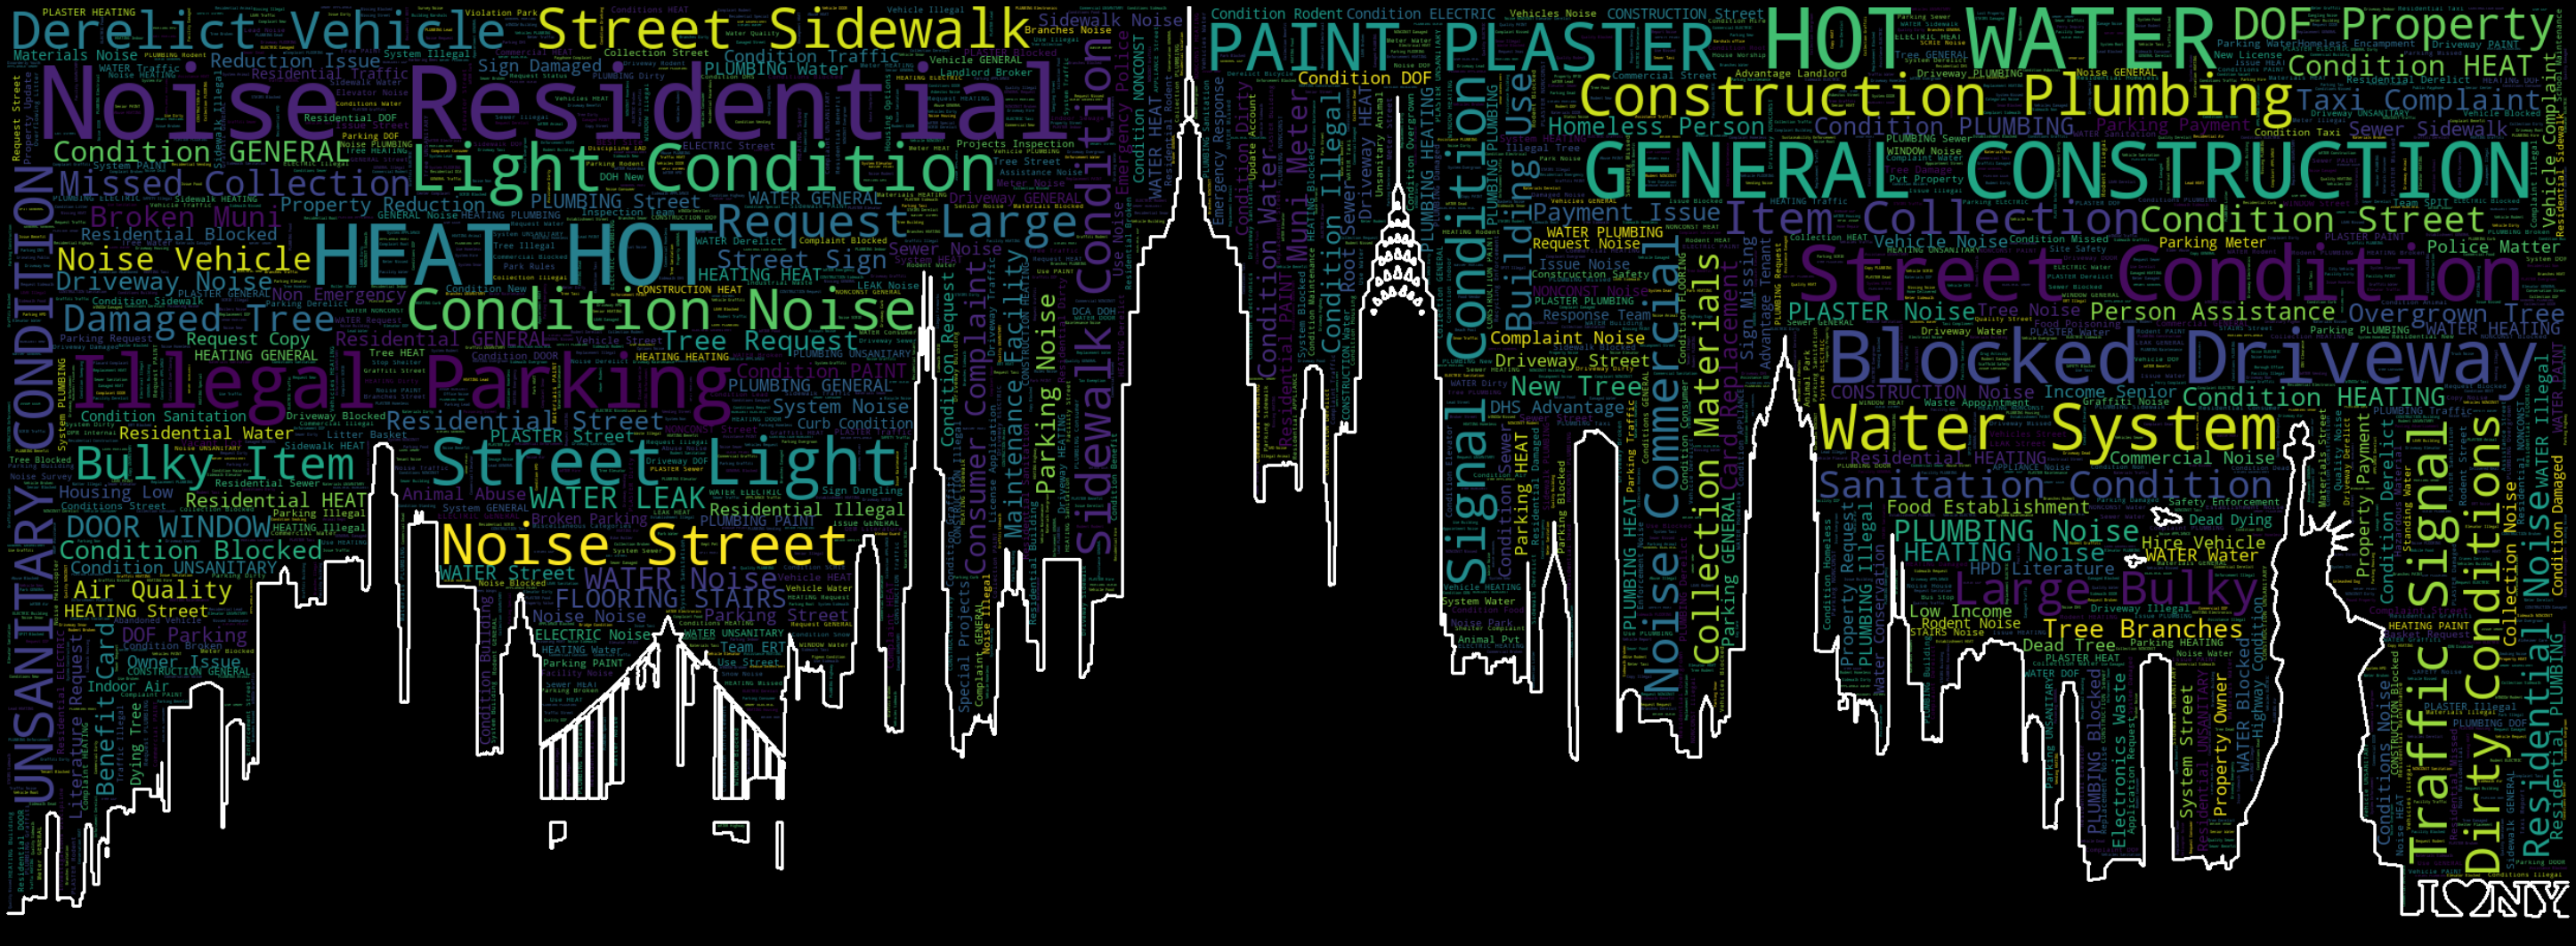

In [46]:
create_wordcloud(df_311, filepath="data/complaint_type_wc.png")

## Classifing Complaints

For our next part, we load a subsample of a dataset as to produce visualisations that are statistically representative of the whole dataset. This can quickly be swapped for the entire dataset if needed. 

In [109]:
import json
import pandas as pd

# Loading sample, and then sub-sampling it because my machine is bad
SAMPLE_PATH = "data/extract.csv"
path_nta = "data/Neighborhood Tabulation Areas.geojson"
path_nta_population = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"
df_sample = pd.read_csv(SAMPLE_PATH)
# Here I subsample the dataset to be able to run the rest, please remove
df_sample = df_sample.sample(5000)
df_sample["Complaint Type"].head()

/Users/szalata/anaconda3/envs/ada/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



14599               Benefit Card Replacement
3794                                   Noise
13811                                  Noise
4120     Request Large Bulky Item Collection
14771                       Dirty Conditions
Name: Complaint Type, dtype: object

A human will see that many complaint types are related to each other, and could be grouped in categories. This is preciselly what we have done, by classifying our complaint types in complaint type classes, as defined below:

In [110]:
with open("complaint_type_cls_legend.json") as fp_legend:
    ct_legend = json.load(fp_legend)
ct_legend

{'noise annoyance': 0,
 'private property condition': 1,
 'public utility condition': 2,
 'human activity disturbance': 3,
 'pest': 4,
 'taxation or advantage program related': 5,
 'general/miscellaneous': 99}

The classes are defined as follows:
- **noise annoyance** aggregates 311 complaints about unwanted noises
- **private property condition** aggregates complaints about the degradation or distrubance caused by private property, specifically immovable objects such as Building Condition, Plumbing, Electrical, etc.
- **public utility condition** aggregates complaints about the degradation or distrubance caused by public infrastructure of New York City. This contains Bus Stop Shelter Complaint, Public Payphone Complaint, DEP Street Condition, etc.
- **human activity disturbance** aggregates those complaints that are not due to property but instead by human activity such as Illegal Parking, Taxi Complaint, Consumer Complaint, etc.
- **pest** aggregates those compaints that are due to animals (but not kept as pets).
- **taxation or advantage program related** aggregates those complaints that are administrative in nature, such as DCA / DOH New License Application Request, DOF Property - Payment Issue, DOF Property - Request Copy, etc.
- **general/miscellaneous** compiles the remaining complaints too general to classify in the previous categories

We load the classification that is serliazed within a json file.

In [111]:
with open("complaint_type_cls.json") as fp_data:
    ct_data = json.load(fp_data)
ct_data

{'Noise - Residential': 0,
 'HEAT/HOT WATER': 1,
 'Street Condition': 2,
 'Street Light Condition': 2,
 'Illegal Parking': 3,
 'HEATING': 1,
 'Blocked Driveway': 3,
 'PLUMBING': 1,
 'Water System': 1,
 'GENERAL CONSTRUCTION': 0,
 'Noise': 0,
 'General Construction/Plumbing': 1,
 'Noise - Street/Sidewalk': 0,
 'Traffic Signal Condition': 2,
 'UNSANITARY CONDITION': 1,
 'Sewer': 2,
 'Dirty Conditions': 1,
 'PAINT/PLASTER': 1,
 'Noise - Commercial': 0,
 'PAINT - PLASTER': 1,
 'ELECTRIC': 1,
 'Request Large Bulky Item Collection': 3,
 'Damaged Tree': 2,
 'Sanitation Condition': 1,
 'Rodent': 4,
 'Building/Use': 1,
 'NONCONST': 99,
 'Missed Collection (All Materials)': 3,
 'Noise - Vehicle': 0,
 'Sidewalk Condition': 2,
 'Derelict Vehicles': 2,
 'Derelict Vehicle': 2,
 'DOOR/WINDOW': 1,
 'WATER LEAK': 1,
 'Broken Muni Meter': 2,
 'Consumer Complaint': 3,
 'Taxi Complaint': 3,
 'New Tree Request': 2,
 'GENERAL': 99,
 'Overgrown Tree/Branches': 2,
 'Graffiti': 3,
 'FLOORING/STAIRS': 1,
 'Main

We augment our dataset with the Complaint Type Class of each sample, by inverse mapping with our legend

In [112]:
df_sample["Complaint Type Class Index"] = df_sample["Complaint Type"].apply(lambda k: ct_data[k])
ct_legend_inv = {v:k for k, v in ct_legend.items()}
df_sample["Complaint Type Class"] = df_sample["Complaint Type Class Index"].apply(lambda k: ct_legend_inv[k])
df_sample.head()

Unique Key            Created Date             Closed Date Agency  \
14599    33208425  04/25/2016 04:22:18 PM  04/25/2016 04:22:45 PM    HRA   
3794     33337347  05/12/2016 04:07:00 AM  05/12/2016 03:00:00 PM    DEP   
13811    34559567  10/17/2016 01:25:00 PM  10/26/2016 12:45:00 PM    DEP   
4120     37422982  10/14/2017 06:01:00 PM  10/20/2017 10:30:00 PM   DSNY   
14771    25808890  06/24/2013 12:40:00 PM  06/26/2013 12:00:00 PM   DSNY   

                                  Agency Name  \
14599            HRA Benefit Card Replacement   
3794   Department of Environmental Protection   
13811  Department of Environmental Protection   
4120                 Department of Sanitation   
14771          P - Brooklyn and Staten Island   

                            Complaint Type  \
14599             Benefit Card Replacement   
3794                                 Noise   
13811                                Noise   
4120   Request Large Bulky Item Collection   
14771                     Dirty Conditions   

                                Descriptor       Location Type Incident Zip  \
14599                           Food Stamp  NYC Street Address          NaN   
3794                   Noise: Alarms (NR3)                 NaN        11366   
13811             Noise, Barking Dog (NR5)                 NaN        10309   
4120   Request Large Bulky Item Collection            Sidewalk        11379   
14771     E12 Illegal Dumping Surveillance            Sidewalk        11218   

                 Incident Address  ... Taxi Pick Up Location  \
14599                         NaN  ...                   NaN   
3794        159-06 UNION TURNPIKE  ...                   NaN   
13811              7 NORMAN PLACE  ...                   NaN   
4120              68-14 79 STREET  ...                   NaN   
14771  3013 FORT HAMILTON PARKWAY  ...                   NaN   

      Bridge Highway Name Bridge Highway Direction Road Ramp  \
14599                 NaN                      NaN       NaN   
3794                  NaN                      NaN       NaN   
13811                 NaN                      NaN       NaN   
4120                  NaN                      NaN       NaN   
14771                 NaN                      NaN       NaN   

      Bridge Highway Segment   Latitude  Longitude  \
14599                    NaN        NaN        NaN   
3794                     NaN  40.720328 -73.807761   
13811                    NaN  40.517200 -74.193648   
4120                     NaN  40.710777 -73.873422   
14771                    NaN  40.648395 -73.978580   

                                       Location Complaint Type Class Index  \
14599                                       NaN                          3   
3794   (40.720328269590894, -73.80776061338688)                          0   
13811   (40.51719991806735, -74.19364777861965)                          0   
4120    (40.71077682742129, -73.87342188062203)                          3   
14771   (40.64839534362075, -73.97857982942419)                          1   

             Complaint Type Class  
14599  human activity disturbance  
3794              noise annoyance  
13811             noise annoyance  
4120   human activity disturbance  
14771  private property condition  

[5 rows x 43 columns]

Let's visualize the current distribution of Complaint Type Classes:

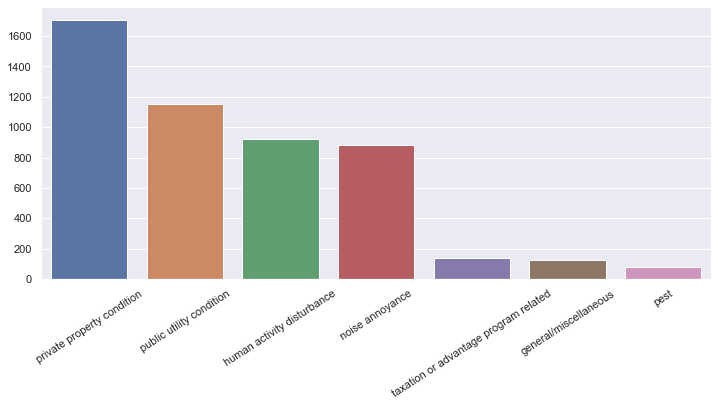

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 5))
ctc_vcounts = df_sample["Complaint Type Class"].value_counts()
ax = sns.barplot(x=ctc_vcounts.index, y=ctc_vcounts.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=33)

ax

# Ranking NTAs

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go

import python_scripts.plotting as plotting

%matplotlib inline

There exist several ways to split a city in meaningful ways. Blocks, districts, boroughs,... But in New York City, it's interesting to consider Neighborhood Tabulation Areas (formerly "Neighborhood Projection Areas"), or simply NTAs.

According to NYC official website: _[NTAs] were created to project populations at a small area level, from 2000 to 2030 for PlaNYC, the long-term sustainability plan for New York City. Since population size affects the error associated with population projections, these geographic units needed to have a minimum population, which we determined to be 15,000. This criterion resulted in combinations of neighborhoods that probably would not occur if one were solely designating boundaries of historical neighborhoods._

It becomes interesting to compare NTAs between them with an innovative criterion: the number of requests made concerning each of them. With that, and because they have a relatively similar count of inhabitants, we are able to "rank" them according to certain criterions. With that, we could help recommend arriving citizens some favorable places according to their preferences: if noise is a real problem for them, we would recommend them not to settle in a place with many requests linked to noise. We have access to the population data of the NTAs (2010 census), which will allow us to construct a better ranking scheme that normalizes the number of complaints by the population size of the NTA.

In [2]:
# Selected columns, NTA associated to a 311 requests was added through an external script
cleaned_311_path = "data/NTA_and_CTC_output.pkl"
# NTA geojson, used to locate NTAs and the borders between them
nta_path = "data/Neighborhood Tabulation Areas.geojson"
# 2010 census: population of the NTAs
nta_population_path = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"

In [3]:
nta_pop_df = pd.read_csv(nta_population_path)

In [4]:
df_311 = pd.read_pickle(cleaned_311_path)
df_311["Complaint Type Class"] = df_311["Complaint Type Class"].astype("category")
df_311.head()

Created Date         Closed Date Agency  \
Unique Key                                                  
32438412   2016-01-17 22:12:35 2016-01-17 23:14:02   NYPD   
32438413   2016-01-17 15:23:56 2016-01-17 19:28:40   NYPD   
32438414   2016-01-17 19:04:42 2016-01-19 08:49:00    DOT   
32438415   2016-01-17 18:46:31 2016-01-17 19:51:41   NYPD   
32438416   2016-01-18 00:02:23 2016-01-18 16:51:22   NYPD   

                                Agency Name       Complaint Type   Latitude  \
Unique Key                                                                    
32438412    New York City Police Department  Noise - Residential  40.861404   
32438413    New York City Police Department  Noise - Residential  40.841828   
32438414       Department of Transportation     Street Condition  40.761218   
32438415    New York City Police Department   Noise - Commercial  40.651177   
32438416    New York City Police Department  Noise - Residential  40.636969   

            Longitude  Complaint Type Class Index      Complaint Type Class  \
Unique Key                                                                    
32438412   -73.903217                           0           noise annoyance   
32438413   -73.937822                           0           noise annoyance   
32438414   -73.912766                           2  public utility condition   
32438415   -73.941618                           0           noise annoyance   
32438416   -73.958533                           0           noise annoyance   

             NTA  
Unique Key        
32438412    BX30  
32438413    MN36  
32438414    QN70  
32438415    BK91  
32438416    BK42

In [5]:
# Add columns for date, weekday and hour of creation
df_311["Created Year"] = df_311["Created Date"].dt.year
df_311["Created Day"] = df_311["Created Date"].dt.date
df_311["Created Hour"] = df_311["Created Date"].dt.hour
df_311["Created Weekday"] = df_311["Created Date"].dt.dayofweek

df_311.head()

Created Date         Closed Date Agency  \
Unique Key                                                  
32438412   2016-01-17 22:12:35 2016-01-17 23:14:02   NYPD   
32438413   2016-01-17 15:23:56 2016-01-17 19:28:40   NYPD   
32438414   2016-01-17 19:04:42 2016-01-19 08:49:00    DOT   
32438415   2016-01-17 18:46:31 2016-01-17 19:51:41   NYPD   
32438416   2016-01-18 00:02:23 2016-01-18 16:51:22   NYPD   

                                Agency Name       Complaint Type   Latitude  \
Unique Key                                                                    
32438412    New York City Police Department  Noise - Residential  40.861404   
32438413    New York City Police Department  Noise - Residential  40.841828   
32438414       Department of Transportation     Street Condition  40.761218   
32438415    New York City Police Department   Noise - Commercial  40.651177   
32438416    New York City Police Department  Noise - Residential  40.636969   

            Longitude  Complaint Type Class Index      Complaint Type Class  \
Unique Key                                                                    
32438412   -73.903217                           0           noise annoyance   
32438413   -73.937822                           0           noise annoyance   
32438414   -73.912766                           2  public utility condition   
32438415   -73.941618                           0           noise annoyance   
32438416   -73.958533                           0           noise annoyance   

             NTA  Created Year Created Day  Created Hour  Created Weekday  
Unique Key                                                                 
32438412    BX30          2016  2016-01-17            22                6  
32438413    MN36          2016  2016-01-17            15                6  
32438414    QN70          2016  2016-01-17            19                6  
32438415    BK91          2016  2016-01-17            18                6  
32438416    BK42          2016  2016-01-18             0                0

### Neighborhood Tabulation Areas (NTAs)

We will use NTA population sizes to normalize the number of 311 requests, which will lead to a better ranking scheme.

In [6]:
# Using the latest census to estimate population size of an NTA
nta_pop_df = nta_pop_df[nta_pop_df["Year"] == 2010][["NTA Code", "NTA Name", "Population"]].set_index("NTA Code")

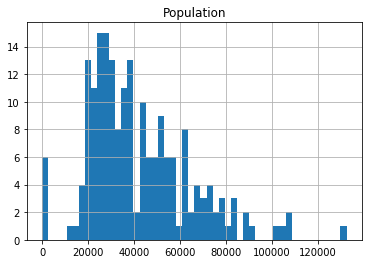

In [7]:
nta_pop_df.hist(bins=50);

There seem to be some outliers, some NTAs have a very small population and should be invastigated before appearing in a ranking of the NTAs. A cutoff with respect to the population size should reveal the 6 outliers:

In [8]:
threshold = 10000

In [9]:
nta_pop_df[nta_pop_df.Population < threshold].sort_values("Population")

NTA Name  Population
NTA Code                                             
QN98                              Airport           0
SI99      park-cemetery-etc-Staten Island           0
BK99           park-cemetery-etc-Brooklyn         418
QN99             park-cemetery-etc-Queens         436
MN99          park-cemetery-etc-Manhattan        1849
BX99              park-cemetery-etc-Bronx        1906

The NTAs above are an airport / parks and cemeteries, which explains the small population sizes.

In [10]:
nta_pop_df[nta_pop_df.Population > threshold].sort_values("Population")

NTA Name  Population
NTA Code                                             
BX98                        Rikers Island       11091
BK93                        Starrett City       13354
SI14      Grasmere-Arrochar-Ft. Wadsworth       16079
SI35             New Brighton-Silver Lake       17525
BK23                        West Brighton       17750
...                                   ...         ...
BK61                  Crown Heights North      103169
BK42                             Flatbush      105804
BK88                         Borough Park      106357
QN28                      Jackson Heights      108152
MN12                      Upper West Side      132378

[189 rows x 2 columns]

We decided not to consider in our analysis the NTAs that have a population size smaller than 10.000, hence to drop the corresponding complaints, as the population size and nature of the concerned NTAs would most likely result in a misinterpretation of our ranking.

In [11]:
invalid_ntas = nta_pop_df[nta_pop_df.Population < threshold].index.tolist()
df_311 = df_311[~df_311.NTA.isin(invalid_ntas)]

### Ranking

In [12]:
nta_complaints = df_311.groupby("NTA") \
                       .count()["Created Date"] \
                       .reset_index() \
                       .rename(columns={"Created Date": "Number of complaints"})

A naive ranking would only look at the number of complaints per NTA. Since we have access to population sizes, a more sensible ranking scheme takes into account the population size of an NTA.

In [13]:
nta_complaints = nta_complaints.merge(nta_pop_df, left_on="NTA", right_index=True).set_index("NTA")
nta_complaints["Complaints per 1k capita"] = 1000 * nta_complaints["Number of complaints"] / nta_complaints["Population"]
nta_complaints["Number of complaints rank"] = nta_complaints["Number of complaints"].rank(method="first")
nta_complaints["Complaints per 1k capita rank"] = nta_complaints["Complaints per 1k capita"].rank(method="first")
nta_complaints = nta_complaints.sort_values(by="Complaints per 1k capita rank")
nta_complaints.head(15)

Number of complaints                          NTA Name  Population  \
NTA                                                                        
BX98                   172                     Rikers Island       11091   
MN50                 11266    Stuyvesant Town-Cooper Village       21049   
BK93                  8148                     Starrett City       13354   
BK23                 11575                     West Brighton       17750   
BX13                 33298                        Co-Op City       43752   
BK72                 32880                      Williamsburg       32926   
QN47                 27031  Ft. Totten-Bay Terrace-Clearview       21751   
MN31                100404       Lenox Hill-Roosevelt Island       80771   
BX46                 37322                       Parkchester       29821   
QN25                 76642                            Corona       57658   
MN32                105319                         Yorkville       77942   
QN02                 35760         Springfield Gardens North       25409   
QN29                130772                          Elmhurst       88427   
QN22                106500                          Flushing       72008   
QN42                 41810                   Oakland Gardens       28237   

      Complaints per 1k capita  Number of complaints rank  \
NTA                                                         
BX98                 15.508070                        1.0   
MN50                535.227327                        3.0   
BK93                610.154261                        2.0   
BK23                652.112676                        4.0   
BX13                761.062351                        9.0   
BK72                998.602928                        8.0   
QN47               1242.747460                        5.0   
MN31               1243.069914                      112.0   
BX46               1251.534154                       12.0   
QN25               1329.251795                       74.0   
MN32               1351.248364                      117.0   
QN02               1407.375339                       11.0   
QN29               1478.869576                      140.0   
QN22               1479.002333                      119.0   
QN42               1480.681376                       18.0   

      Complaints per 1k capita rank  
NTA                                  
BX98                            1.0  
MN50                            2.0  
BK93                            3.0  
BK23                            4.0  
BX13                            5.0  
BK72                            6.0  
QN47                            7.0  
MN31                            8.0  
BX46                            9.0  
QN25                           10.0  
MN32                           11.0  
QN02                           12.0  
QN29                           13.0  
QN22                           14.0  
QN42                           15.0

In [14]:
columns = ["NTA Name", "Population", "Number of complaints", "Complaints per 1k capita rank", "Number of complaints rank"]

fig = go.Figure(data=[go.Table(
    columnwidth=40,
    header=dict(values=columns,
                fill_color='rgb(250,128,114)',
                font=dict(color='black'),
                align='center'),
    cells=dict(values=nta_complaints[columns].head(12).to_numpy().T,
               fill_color='gray',
               align=['center', 'left'],
               height=30))
],
               layout_title_text="Ranking of NTAs based on number of complaints per capita")

fig.update_layout(template="plotly_dark")
plotly.offline.plot(fig, filename='plots/nta_ranking.html')

'plots/nta_ranking.html'

One NTA really stands out, both in terms of total complaints and complaints per capita: _Rikers Island_. This example highlights the fact that no ranking is perfect and should therefore be taken with a grain of salt, we would not recommend moving to that island as it is _a 1.67 km2 island in the East River between Queens and the Bronx that is home to New York City's main jail complex_. 

Interesting fact about  _Stuyvesant Town-Cooper Village_ and _Starrett City_: both NTAs have their own public safety forces, which might explain why they have so few complaints per capita. In fact, _Starrett City_ had one of the city's lowest crime rates, mainly because of the existence of the security force. This private security force has been used as a case study in the advantages of private security over public policing.

### Evolution of complaints per capita

We might also want to take a look at possible improvements in NTAs over the years, if for instance a specific problem has been tackled by the local authorities. Because of the upward trend of the 311 service requests, we cannot just look at the total number of complaints per year per year, but should rather check how the number of complaints per capita compare to the city-wide average per year.

In [28]:
# We have decide to drop complaints associated to Rikers Island, since a prison island is not the "usual" neighborhood we are interested in
nta_pop_df[nta_pop_df["NTA Name"] == "Rikers Island"]

NTA Name  Population
NTA Code                           
BX98      Rikers Island       11091

In [30]:
invalid_ntas.append('BX98')
df_311 = df_311[~df_311.NTA.isin(invalid_ntas)]

In [31]:
yearly_complaints = df_311.groupby("Created Year") \
                          .count()["Created Date"] \
                          .reset_index() \
                          .rename(columns={"Created Date": "Yearly complaints"})

total_population = nta_pop_df.Population.sum()
yearly_complaints["Yearly complaints per 1k capita"] = 1000 * yearly_complaints["Yearly complaints"] / total_population

In [32]:
nta_yearly_complaints = df_311.groupby(["NTA", "Created Year"]) \
                              .count()["Created Date"] \
                              .reset_index() \
                              .rename(columns={"Created Date": "Total complaints"})
nta_yearly_complaints = nta_yearly_complaints.merge(yearly_complaints, on="Created Year")
nta_yearly_complaints = nta_yearly_complaints.merge(nta_pop_df, left_on="NTA", right_index=True)
nta_yearly_complaints.head()

NTA  Created Year  Total complaints  Yearly complaints  \
0    BK09          2010              3535            1768261   
188  BK09          2011              3331            1698951   
376  BK09          2012              3559            1579297   
564  BK09          2013              3440            1607366   
752  BK09          2014              4287            1897785   

     Yearly complaints per 1k capita                      NTA Name  Population  
0                         216.297521  Brooklyn Heights-Cobble Hill       22887  
188                       207.819371  Brooklyn Heights-Cobble Hill       22887  
376                       193.183034  Brooklyn Heights-Cobble Hill       22887  
564                       196.616495  Brooklyn Heights-Cobble Hill       22887  
752                       232.141177  Brooklyn Heights-Cobble Hill       22887

In [33]:
nta_yearly_complaints["Complaints per 1k capita"] = 1000 * nta_yearly_complaints["Total complaints"] / nta_yearly_complaints["Population"]
nta_yearly_complaints["Factor"] = nta_yearly_complaints["Complaints per 1k capita"] / nta_yearly_complaints["Yearly complaints per 1k capita"]
nta_yearly_complaints.sort_values(by="Factor", ascending=False)

NTA  Created Year  Total complaints  Yearly complaints  \
1224  MN17          2016             30074            2171196   
660   MN17          2013             18069            1607366   
1412  MN17          2017             24711            2274417   
472   MN17          2012             16948            1579297   
1788  MN17          2019             20129            1931348   
...    ...           ...               ...                ...   
113   MN50          2010               977            1768261   
1805  MN50          2019              1010            1931348   
47    BK93          2010               551            1768261   
1617  MN50          2018              1198            2534993   
1429  MN50          2017              1031            2274417   

      Yearly complaints per 1k capita                        NTA Name  \
1224                       265.585404           Midtown-Midtown South   
660                        196.616495           Midtown-Midtown South   
1412                       278.211621           Midtown-Midtown South   
472                        193.183034           Midtown-Midtown South   
1788                       236.246676           Midtown-Midtown South   
...                               ...                             ...   
113                        216.297521  Stuyvesant Town-Cooper Village   
1805                       236.246676  Stuyvesant Town-Cooper Village   
47                         216.297521                   Starrett City   
1617                       310.085842  Stuyvesant Town-Cooper Village   
1429                       278.211621  Stuyvesant Town-Cooper Village   

      Population  Complaints per 1k capita    Factor  
1224       28630               1050.436605  3.955174  
660        28630                631.121202  3.209910  
1412       28630                863.115613  3.102371  
472        28630                591.966469  3.064278  
1788       28630                703.073699  2.976015  
...          ...                       ...       ...  
113        21049                 46.415507  0.214591  
1805       21049                 47.983277  0.203107  
47         13354                 41.261045  0.190761  
1617       21049                 56.914818  0.183545  
1429       21049                 48.980949  0.176056  

[1880 rows x 9 columns]

In [34]:
path_nta = "data/Neighborhood Tabulation Areas.geojson"

with open(path_nta) as f:
    geojson = json.load(f)

features = plotting.get_features(nta_yearly_complaints, geojson, "NTA", "Created Year", "ntacode", "Factor")
m = plotting.map_features(features)
m.save("maps/factors.html")

### Comparison of selected NTAs

Finally, while a general rankinkg that looks at all types of complaints certainly is helpful, people have different preferences when it comes to choosing a place to live. For instance one might not care about the fact that there are frequently problems with the infractructure of a neighborhood (brooken streetlight, graffitis on the walls, but be very sensitive to noise. This is why we now take a closer look at a selection of NTAs, that already have the lowest number of complaints per capita, but distinguish between different Complaint Categegory Classes (CTCs), to see how the NTAs perform in each category, with respect to the city-wide average. 

In [18]:
complaint_type_classes = df_311.groupby("Complaint Type Class") \
                               .count()["Created Date"] \
                               .sort_values(ascending=False)

complaint_type_classes

Complaint Type Class
private property condition               7160626
public utility condition                 3955732
noise annoyance                          3791741
human activity disturbance               3607766
general/miscellaneous                     669524
pest                                      307687
unclassified                               18098
taxation or advantage program related      15461
Name: Created Date, dtype: int64

Here we only focus on the top-4 complaints, because they contribute most to the total number of complaints and are particularly relevant for most people that decide whether or not to move to a certain neighborhood.

In [19]:
selected_classes = complaint_type_classes.index.tolist()[:4]
complaint_type_classes = complaint_type_classes[selected_classes].reset_index() \
                                                                 .rename(columns={"Created Date": "Count"})
complaint_type_classes["Class complaints per 1k capita"] = 1000 * complaint_type_classes["Count"] / total_population
complaint_type_classes.head()

Complaint Type Class    Count  Class complaints per 1k capita
0  private property condition  7160626                      875.903303
1    public utility condition  3955732                      483.873718
2             noise annoyance  3791741                      463.813983
3  human activity disturbance  3607766                      441.309762

In [20]:
nta_complaints_per_class = df_311[df_311["Complaint Type Class"].isin(selected_classes)] \
                                 .groupby(["NTA", "Complaint Type Class"]) \
                                 .count()["Created Date"] \
                                 .reset_index() \
                                 .rename(columns={"Created Date": "Number of complaints"}) \
                                 .dropna()

nta_complaints_per_class.head()

NTA        Complaint Type Class  Number of complaints
1  BK09  human activity disturbance                9175.0
2  BK09             noise annoyance                9364.0
4  BK09  private property condition               10792.0
5  BK09    public utility condition               13138.0
9  BK17  human activity disturbance               28217.0

In [21]:
nta_complaints_per_class = nta_complaints_per_class.merge(nta_pop_df, left_on="NTA", right_index=True)
nta_complaints_per_class = nta_complaints_per_class.merge(complaint_type_classes, on="Complaint Type Class")
nta_complaints_per_class["NTA complaints per 1k capita"] = 1000 * nta_complaints_per_class["Number of complaints"] / nta_complaints_per_class["Population"]
nta_complaints_per_class["Factor"] = nta_complaints_per_class["NTA complaints per 1k capita"] / nta_complaints_per_class["Class complaints per 1k capita"]
nta_complaints_per_class.head()

NTA        Complaint Type Class  Number of complaints  \
0  BK09  human activity disturbance                9175.0   
1  BK17  human activity disturbance               28217.0   
2  BK19  human activity disturbance               13974.0   
3  BK21  human activity disturbance                7670.0   
4  BK23  human activity disturbance                1777.0   

                                      NTA Name  Population    Count  \
0                 Brooklyn Heights-Cobble Hill       22887  3607766   
1  Sheepshead Bay-Gerritsen Beach-Manhattn Bch       64518  3607766   
2                               Brighton Beach       35547  3607766   
3                         Seagate-Coney Island       31965  3607766   
4                                West Brighton       17750  3607766   

   Class complaints per 1k capita  NTA complaints per 1k capita    Factor  
0                      441.309762                    400.882597  0.908393  
1                      441.309762                    437.350817  0.991029  
2                      441.309762                    393.113343  0.890788  
3                      441.309762                    239.949945  0.543722  
4                      441.309762                    100.112676  0.226854

In [22]:
factor_table = nta_complaints_per_class.pivot(index="NTA Name", columns="Complaint Type Class", values="Factor")
factor_table.head()

Complaint Type Class                        human activity disturbance  \
NTA Name                                                                 
Allerton-Pelham Gardens                                       0.903790   
Annadale-Huguenot-Prince's Bay-Eltingville                    1.024547   
Arden Heights                                                 1.003791   
Astoria                                                       1.160815   
Auburndale                                                    1.219456   

Complaint Type Class                        noise annoyance  \
NTA Name                                                      
Allerton-Pelham Gardens                            0.530748   
Annadale-Huguenot-Prince's Bay-Eltingville         0.248523   
Arden Heights                                      0.199219   
Astoria                                            1.017286   
Auburndale                                         0.254679   

Complaint Type Class                        private property condition  \
NTA Name                                                                 
Allerton-Pelham Gardens                                       0.573150   
Annadale-Huguenot-Prince's Bay-Eltingville                    0.537991   
Arden Heights                                                 0.388853   
Astoria                                                       0.676997   
Auburndale                                                    0.464128   

Complaint Type Class                        public utility condition  
NTA Name                                                              
Allerton-Pelham Gardens                                     1.383371  
Annadale-Huguenot-Prince's Bay-Eltingville                  2.217728  
Arden Heights                                               1.459384  
Astoria                                                     0.928609  
Auburndale                                                  2.034099

In [23]:
selected_ntas = nta_complaints["NTA Name"].values.tolist()[1:21]
selected_factors = factor_table.loc[selected_ntas]
complaint_factors = selected_factors.to_numpy().T

In [24]:
fig = go.Figure(
    data=go.Heatmap(
        z=complaint_factors,
        x=selected_ntas,
        y=selected_classes,
        colorscale='Viridis')
    )
fig.update_layout(title="Counts per capita scaling factor (vs city-wide average) of selected NTAs", template="plotly_dark")
fig.update_xaxes(tickangle=45)
plotly.offline.plot(fig, filename='plots/nta_heatmap.html')

'plots/nta_heatmap.html'

# Closer look at NYPD in Boroughs and Districts

In [ ]:
count_by_agency = df_311.groupby("Agency").count()["Created Date"]

In [169]:
name_mapping = {"NYPD": "Police Department", "HPD": "Housing Preservation & Development",
                "DOT": "Department of Transportation", "DSNY": "Sanitation Department",
                "DEP": "Department of Environmental Protection Police"}
count_by_agency = count_by_agency.sort_values(ascending=False).rename(name_mapping)
count_by_agency = count_by_agency / count_by_agency.sum()

In [170]:
layout = go.Layout(
    yaxis = go.layout.YAxis(
        tickformat = '%'
    )
)
fig = go.Figure(
    data=go.Bar(x=count_by_agency.keys()[:5], y=count_by_agency.values[:5],
        marker=dict(
        color='rgb(250,128,114)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
        text=count_by_agency.values[:5].round(2),
        textposition = 'auto',
        opacity=0.6),
    layout=layout,
    layout_title_text="Percentage of 3-1-1 calls by agency"
)
fig.update_layout(template="plotly_dark")
plotly.offline.plot(fig, filename='.html')
fig.show()

'.html'

We note that NYPD receives many calls and together with Housing Preservation and Development make up over 50% of the total. We decide to focus on NYPD.

In [175]:
df_311_nypd = df_311[df_311["Agency"] == "NYPD"]
df_311_nypd = df_311_nypd[["Created Date", "Closed Date", "Complaint Type", "Descriptor", "Borough", "Open Data Channel Type", "Year"]]
population_by_borough = pd.read_csv("data/NYC_Population_by_Borough.csv")
population_by_borough["Borough"] = population_by_borough["Borough"].apply(lambda x: x.upper())
population_by_borough.set_index("Borough", inplace=True)
nypd_borough_population = df_311_nypd.groupby("Borough")[["Complaint Type"]].count().join(population_by_borough)[:-1]

What sort of problems are tackled by NYPD through 311?

In [197]:
most_common_nypd = df_311_nypd.groupby("Complaint Type").agg("size").sort_values(ascending=False)[:10]

In [198]:
most_common_nypd

Complaint Type
Noise - Residential            1768561
Blocked Driveway                893640
Illegal Parking                 880850
Noise - Street/Sidewalk         465079
Noise - Commercial              342596
Noise - Vehicle                 211727
Derelict Vehicle                207800
Non-Emergency Police Matter      66737
Animal Abuse                     52177
Vending                          41537
dtype: int64

In [176]:
all_borough_population = df_311.groupby("Borough")[["Complaint Type"]].count().join(population_by_borough)[:-1]

We want to see how important those problems are in a borough. As a metric we use the proportion of all 311 calls they make.

In [190]:
nypd_vs_all = (nypd_borough_population["Complaint Type"] / all_borough_population["Complaint Type"]).sort_values()

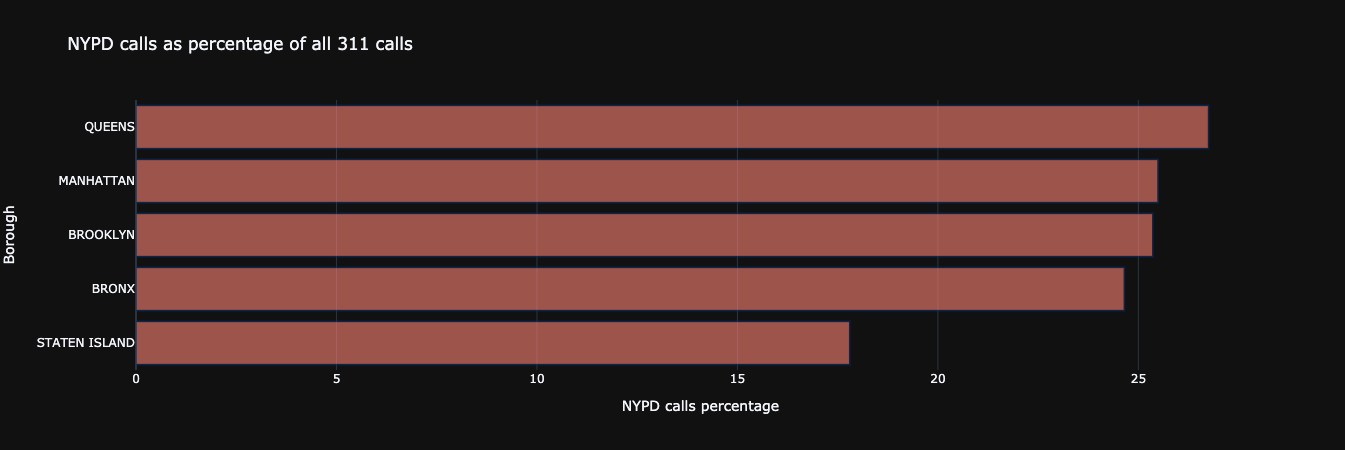

In [192]:
fig = go.Figure(
    data=go.Bar(y=nypd_vs_all.keys(), x=(nypd_vs_all.values * 100).round(2).astype(float),
        marker=dict(
        color='rgb(250,128,114)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
        orientation='h',
        opacity=0.6),
    layout_title_text="NYPD calls as percentage of all 311 calls"
)
fig.update_layout(template="plotly_dark", yaxis_title="Borough", xaxis_title="NYPD calls percentage",
                  yaxis_type="category")
plotly.offline.plot(fig, filename='plots/nypd_vs_all.html')
fig.show()

Top problems by borough

In [ ]:
list_by_borough = df_311_nypd.groupby("Borough")["Complaint Type"].apply(list)
boroughs = list(list_by_borough.index.categories)[:-1]
complaint_type_borough = pd.concat((pd.DataFrame(dict(Counter(list_by_borough[i])), index=[boroughs[i]]).transpose() for i in range(len(boroughs))), axis=1)

In [217]:
complaint_type_borough.fillna(0, inplace=True)
complaint_type_borough.reset_index(inplace=True)

In [246]:
top_problems = pd.concat((complaint_type_borough.sort_values(boroughs[i], ascending=False).reset_index()["index"][:10] for i in range(len(boroughs))), axis=1)
top_problems.columns = boroughs
top_problems.reset_index(inplace=True)
top_problems.rename(columns={"index": "Rank"}, inplace=True)

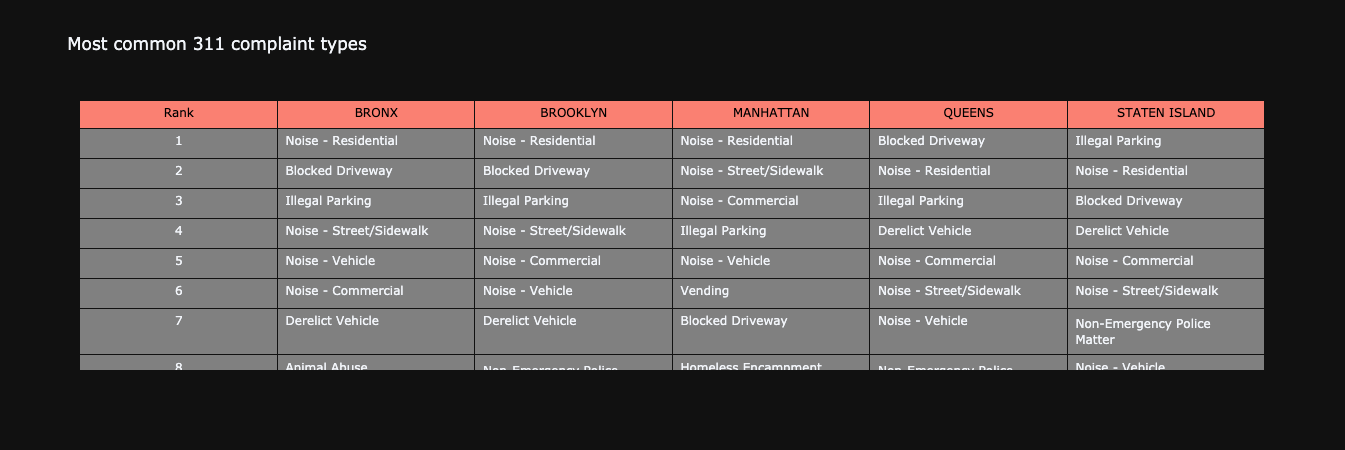

In [247]:
fig = go.Figure(data=[go.Table(
    columnwidth=40,
    header=dict(values=list(top_problems.columns),
                fill_color='rgb(250,128,114)',
                font=dict(color='black'),
                align='center'),
    cells=dict(values=[top_problems.index + 1, top_problems.BRONX, top_problems.BROOKLYN, top_problems.MANHATTAN, top_problems.QUEENS, top_problems["STATEN ISLAND"]],
               fill_color='gray',
               align=['center', 'left'],
              height=30))
],
               layout_title_text="Most common 311 complaint types")

fig.update_layout(template="plotly_dark")
plotly.offline.plot(fig, filename='plots/common_complaints.html')
fig.show()

# Seasonality

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import pickle as pk
import seaborn as sns
import plotly.graph_objects as go
import plotly

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
with open("data/311_Service_Requests_from_2010_to_Present_cleaned.pkl", 'rb') as f:
    df_311 = pk.load(f)

In [4]:
df_311['Complaint Type'].cat.remove_unused_categories(inplace=True)
df_311 = df_311.assign(Quantity=pd.Series(np.ones(len(df_311.index))).values)

In [12]:
def plot_season(col="Complaint Type", num_labels=30, plotting="plt", frequency="M", date_grouper="Created Date"):
    if plotting not in ["plt", "plotly"]:
        raise NotImplementedError("Invalid plotting method")
    ### compute complaint types with most occurences
    most_freq_labels = [x for x in df_311[col].value_counts().keys().values[:num_labels]]

    ### group requests by month
    season = df_311.groupby([col, pd.Grouper(key=date_grouper, freq=frequency)])['Quantity']\
        .sum().reset_index().sort_values(date_grouper)
    season.fillna({'Quantity': 0}, inplace=True)


    ### get corresponding times and quantities 
    times = [season[season[col] == c][date_grouper] for c in most_freq_labels]
    qts = [season[season[col] == c]['Quantity'] for c in most_freq_labels]

    ### plot
    if plotting.lower() == "plt":
        plt.figure(figsize=(16,8))
        pal = sns.color_palette("Set1")
        plt.stackplot(times[0], qts, labels=most_freq_labels, colors=pal)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.xlabel("Time")
        plt.ylabel("Count of requests")
        plt.title(col)
        plt.show();
    elif plotting.lower() == "plotly":
        fig = go.Figure({"layout": {"title": {"text": col}}})
        for i, (lab, q, t) in enumerate(zip(most_freq_labels, qts, times)):
            fig.add_trace(go.Scatter(
                x=t, y=q,
                hoverinfo='x+y',
                mode='lines',
                name=lab,
                stackgroup='one', # define stack group
                visible= (True if i < 5 else "legendonly")
            ))
        fig.update_layout(template="plotly_dark")
        plotly.offline.plot(fig, filename='plots/{}.html'.format(col.lower().replace(" ", "_")))
        fig.show()
    else:
        raise NotImplementedError("Woups")

## Plot per complaint type

In [13]:
plot_season('Complaint Type', 100, plotting="plotly")

## Plot per agency

In [ ]:
plot_season("Agency", 20, plotting="plotly")

## Plot per descriptor

In [ ]:
plot_season("Descriptor", 30, plotting="plotly")

## Note
The above plots are extremely useful in notebook format. They allow to zoom, move, scroll, select one or multiple categories,take snapshots,... Sadly, the pictures taken by snapshot are not as flexible: we can't chose the size, have a better view of the axis, not chose the scroll level of the legend, on the right (it's always capped at the top). We tried to make clear snapshots and explain them, but nonetheless apologize for the inconvenience.
## Observations

Around March-April 2014, no more _Heating_ entries are registered, but _HEAT/HOT WATER_ start to appear. It's probable it was replaced.

Heating problems are obviously more reported during winter, peaking between December and January of each year.

![Heat/Hot water](images/heatwater.png)

Tree also had a renaming: _Dead Trees_ to _Dead/Dying Trees_. Apparently, they are different!

![Dead trees](images/deadtree.png)

Similarly, _Street Conditions_ are more reported in spring, around March. 

![Street Conditions](images/streetconditions.png)


Noise knows 2 peaks and 2 pits: the heart of summer and winter seem calmer. Probably because less people are in the street, being mostly on holiday (or inside, during winter). Meanwhile spring and autumn have more people around, creating more nuisance.

![Noise](images/noise.png)


Interestingly, while most of requests are gradually growing (due to the service being more and more popular), some manage to keep a steady level, notably Sewers.

Sewers have another funny feature: August 2011 raises from the usual 2-3k monthly requests to 8k requests. It is possible that the reason for that is a light earthquake, that happend August 22nd, possibly disrupting the sewers system.

![Sewers](images/sewer.png)

Rodent appear mostly during summertime

![Rodents](images/rodent.png)

Illegal parking requests are strongly rising, more than the global rate. This would require additional analysis to draw conclusion, but we can suppose either more people park illegally, or people are specially interested in 3-1-1 as a way to denounce illegal parking.

![Parking](images/illegalparking.png)




# Insights about the pest problem relative to NTAs

In [1]:
import pandas as pd
import numpy as np
import folium
import folium.plugins as plugins
import numpy as np
import pandas as pd
import json
import python_scripts.plotting as plotting

In [2]:
path_311 = "data/NTA_and_CTC_output.pkl"
path_nta_population = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"
path_nta = "data/Neighborhood Tabulation Areas.geojson"

with open(path_nta) as f:
    geojson = json.load(f)

df_311 = pd.read_pickle(path_311)
nta_pop_df = pd.read_csv(path_nta_population)
nta_pop_df = nta_pop_df[nta_pop_df.Year == 2010].reset_index()

### _About pests_



The Rat Problem in NYC is so famous that it is honored by its dedicated Wikipedia article. An official channel for pest spotting in NYC is the 3-1-1 report system. Thus, our dataset offers us the opportunity to take a look into the famous Rat Problem, principal component of pest reports aggregated under the complaint type class "pest".

We describe the steps to create a normalized timelapse heatmap/by NTA of pest report calls from 2010 to 2019 in the city.


We ultimately want to represent the intensity of pest problems by NTA using a weight computed from the amount of 311 calls.
We note:
* NTAs have different populations and we can assume population is somewhat proportional to reports count
* 311 entries have been increasing over the decade

We will generate the weight by using the pest 311 entries, normalized per capita, normalized per total number of reports each year. We will restrict our source dataset to entries which contain valid information for date, NTA, for which NTAs contain population count, and which are defined as complaint type class pests. 


### _Pre-processing pests_

How many NTA-undefined entries are present?

In [3]:
df_311[df_311["NTA"].isnull()].shape[0]

4850

We remove 5000 NTA-undefined reports, and contraint our dataset to pest reports (index 4)

In [4]:
df_pests = df_311[~df_311["NTA"].isnull()]

In [5]:
df_pests[df_pests["NTA"].isnull()].shape[0]

0

In [6]:
df_pests = df_pests[df_pests["Complaint Type Class Index"] == 4].copy()
df_pests.shape[0]

308760

We have ~309k entries left. We gather individual date components to analyse temporal trends at different scales.

In [7]:
df_pests["Year"] = df_pests["Created Date"].apply(lambda x: x.year)
df_pests["Month"] = df_pests["Created Date"].apply(lambda x: x.month)
df_pests["Day"] = df_pests["Created Date"].apply(lambda x: x.day)
df_pests["Hour"] = df_pests["Created Date"].apply(lambda x: x.hour)

### _Temporal trends in pests reports_

First, let's take a look at the yearly trend.

Text(0, 0.5, 'Count')

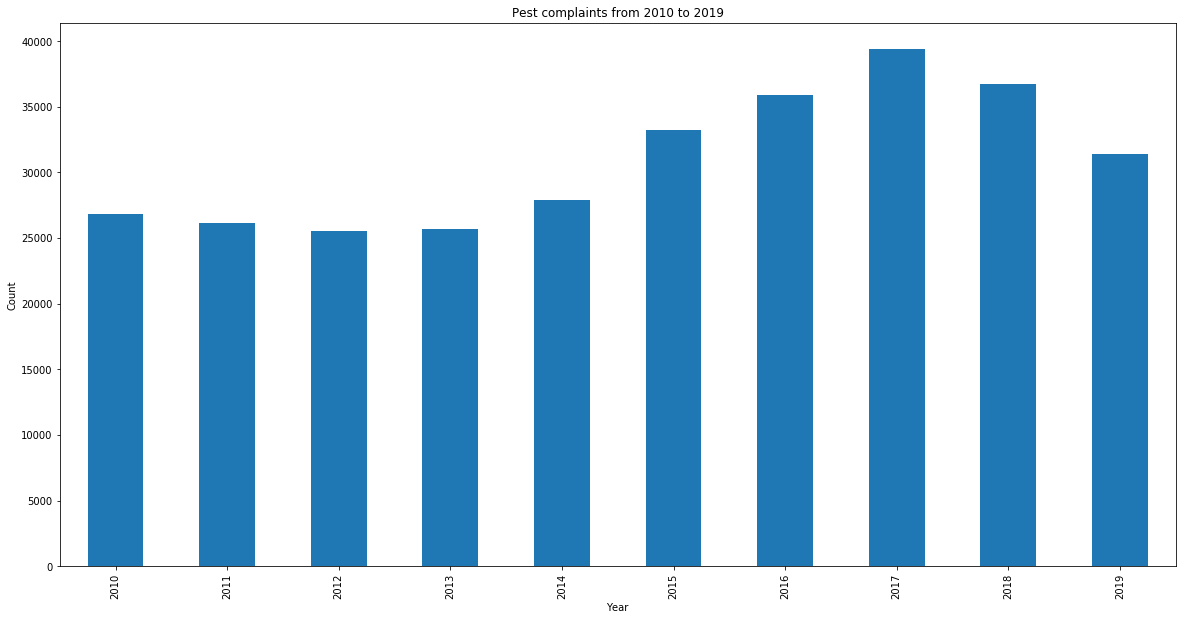

In [8]:
vc = df_pests["Year"].value_counts().sort_index()
ax = vc.plot.bar(figsize=(20,10))
ax.set_title("Pest complaints from 2010 to 2019")
ax.set_xlabel("Year")
ax.set_ylabel("Count")

We observe the general increase in report counts typical of our dataset. Counts increase as reporting technology gets more accessible, and knowledge of 3-1-1 spreads. 2019 count is faulty because of the partial data for this year.

Now, we can take a look at the intra-year or monthly trend.

Text(0, 0.5, 'Count')

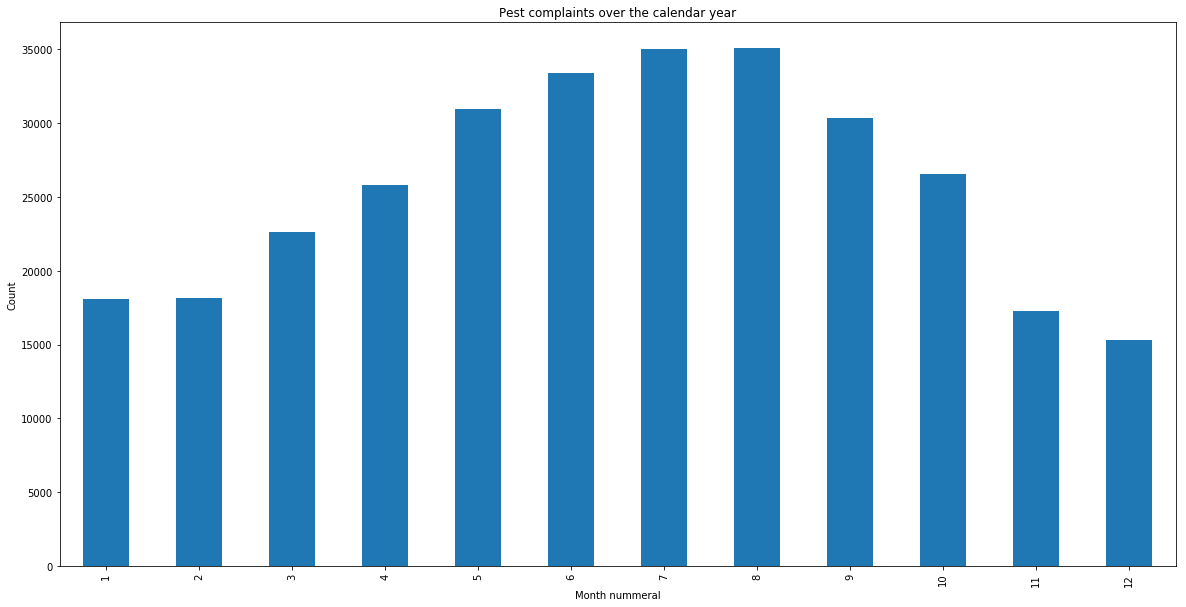

In [9]:
vc = df_pests["Month"].value_counts().sort_index()
ax = vc.plot.bar(figsize=(20,10))
ax.set_title("Pest complaints over the calendar year")
ax.set_xlabel("Month nummeral")
ax.set_ylabel("Count")

We observe an increase in reports during the summer, and a decrease during the winter. This could be entirely explained by the longer time spent outside by humans during summer, increasing sight probability, which is a frequent statistical effect. However, it could be assumed that pests also adventure outside more during the summer, or for longer periods of time, which could contribute to explain the summer peak. 

Looking at intra-month or daily trend was poor in additinal information, it would seem the specific day within the month has no relation on the amount 3-1-1 calls.

Finally, we can look at the intra-day hourly trend.

Text(0, 0.5, 'Count')

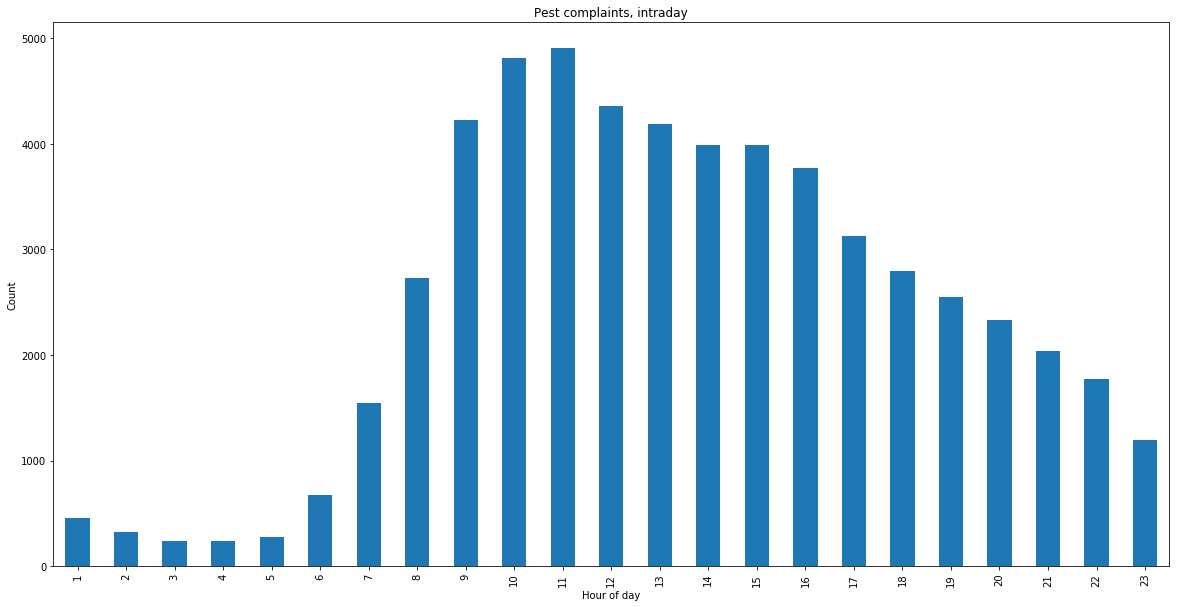

In [10]:

vc = df_pests["Hour"].value_counts().sort_index()
# Remove midnight because many requests logged as hour=0.
vc = vc.iloc[1:]
ax = vc.plot.bar(figsize=(20,10))
ax.set_title("Pest complaints, intraday")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Count")

We observe an increase in reports during the morning, right before lunch. The count correlates with amount of humans that are awoken, but interestingly does not correlate with rush hour, where most new yorkers take the subway, leave their home, and we could imagine would sight most pests.

### _Normalizing counts_

We will now group the data by NTA and by year, and normalize by the explained feature to generate the weight. The weight is a value between 0 and 1, which represent the yearly relative intensity of 3-1-1 calls regarding pests issues. It can be used to generate the heatmap, or to sort NTAs, etc.

In [11]:
nta_pop_df.rename(columns={"NTA Code": "NTA"}, inplace=True)

In [12]:
df_pests_grp = df_pests.groupby(["NTA", "Year"]) \
                                 .count() \
                                 .rename(columns={"Created Date": "Count"})[["Count"]]
df_pests_grp.reset_index(inplace=True)
df_pests_grp.head()

NTA  Year  Count
0  BK09  2010     44
1  BK09  2011     55
2  BK09  2012     51
3  BK09  2013     29
4  BK09  2014     58

#### First normalization: per capita

As "more people = more calls", we remove this variable's influence from the weight.

In [13]:
df_pests_merge = df_pests_grp.merge(nta_pop_df, on="NTA")
df_pests_merge.drop(columns=["index", "Year_y", "FIPS County Code"], inplace=True)
df_pests_merge.rename(columns={"Year_x": "Year"}, inplace=True)
df_pests_merge["Capita Count"] = df_pests_merge["Count"] / df_pests_merge["Population"]
df_pests_merge["Capita Count"] = df_pests_merge["Capita Count"].replace([np.inf, -np.inf], np.nan)
df_pests_merge = df_pests_merge[~df_pests_merge["Capita Count"].isnull()]

In [14]:
df_pests_merge.sort_values(by="Capita Count", ascending=False).head(10)

NTA  Year  Count   Borough                    NTA Name  Population  \
509   BK99  2019     58  Brooklyn  park-cemetery-etc-Brooklyn         418   
507   BK99  2017     51  Brooklyn  park-cemetery-etc-Brooklyn         418   
1753  QN99  2019     43    Queens    park-cemetery-etc-Queens         436   
506   BK99  2016     35  Brooklyn  park-cemetery-etc-Brooklyn         418   
508   BK99  2018     34  Brooklyn  park-cemetery-etc-Brooklyn         418   
502   BK99  2012     30  Brooklyn  park-cemetery-etc-Brooklyn         418   
500   BK99  2010     28  Brooklyn  park-cemetery-etc-Brooklyn         418   
501   BK99  2011     27  Brooklyn  park-cemetery-etc-Brooklyn         418   
1751  QN99  2017     28    Queens    park-cemetery-etc-Queens         436   
1750  QN99  2016     23    Queens    park-cemetery-etc-Queens         436   

      Capita Count  
509       0.138756  
507       0.122010  
1753      0.098624  
506       0.083732  
508       0.081340  
502       0.071770  
500       0.066986  
501       0.064593  
1751      0.064220  
1750      0.052752

In [15]:
df_pests_merge = df_pests_merge[~df_pests_merge["NTA Name"].str.contains("park-cemetery-etc")]
df_pests_merge.sort_values(by="Capita Count", ascending=False).head(10)

NTA  Year  Count    Borough                             NTA Name  \
307  BK64  2017    576   Brooklyn                     Prospect Heights   
309  BK64  2019    534   Brooklyn                     Prospect Heights   
308  BK64  2018    435   Brooklyn                     Prospect Heights   
583  BX10  2013    552      Bronx  Pelham Bay-Country Club-City Island   
675  BX30  2015    578      Bronx                  Kingsbridge Heights   
707  BX34  2017    634      Bronx       Melrose South-Mott Haven North   
306  BK64  2016    314   Brooklyn                     Prospect Heights   
327  BK69  2017    484   Brooklyn                         Clinton Hill   
944  MN11  2019    592  Manhattan                 Central Harlem South   
942  MN11  2017    525  Manhattan                 Central Harlem South   

     Population  Capita Count  
307       19849      0.029019  
309       19849      0.026903  
308       19849      0.021915  
583       26583      0.020765  
675       32496      0.017787  
707       39214      0.016168  
306       19849      0.015819  
327       34791      0.013912  
944       43383      0.013646  
942       43383      0.012102

In [16]:
df_pests_merge.sort_values(by="Capita Count", ascending=True).head(10)

NTA  Year  Count    Borough                        NTA Name  \
872   BX98  2016      1      Bronx                   Rikers Island   
874   BX98  2019      1      Bronx                   Rikers Island   
873   BX98  2017      1      Bronx                   Rikers Island   
870   BX98  2010      1      Bronx                   Rikers Island   
871   BX98  2015      1      Bronx                   Rikers Island   
471   BK93  2011      2   Brooklyn                   Starrett City   
475   BK93  2015      2   Brooklyn                   Starrett City   
1159  MN50  2014      5  Manhattan  Stuyvesant Town-Cooper Village   
1158  MN50  2013      5  Manhattan  Stuyvesant Town-Cooper Village   
476   BK93  2016      4   Brooklyn                   Starrett City   

      Population  Capita Count  
872        11091      0.000090  
874        11091      0.000090  
873        11091      0.000090  
870        11091      0.000090  
871        11091      0.000090  
471        13354      0.000150  
475        13354      0.000150  
1159       21049      0.000238  
1158       21049      0.000238  
476        13354      0.000300

#### Second normalization: by count of calls per year 

We observe that the number of 311 calls increase over the years. Therefore we normalize with this count to get the changes of NTA importance relative to others instead.

In [17]:
df_pests_2norm = df_pests_merge.merge(df_pests["Year"].value_counts(), on="Year")
get_yc = lambda year: df_pests["Year"].value_counts()[year]
df_pests_merge["Year Count"] = df_pests_merge["Year"].apply(get_yc)
df_pests_merge

NTA  Year  Count        Borough                      NTA Name  \
0     BK09  2010     44       Brooklyn  Brooklyn Heights-Cobble Hill   
1     BK09  2011     55       Brooklyn  Brooklyn Heights-Cobble Hill   
2     BK09  2012     51       Brooklyn  Brooklyn Heights-Cobble Hill   
3     BK09  2013     29       Brooklyn  Brooklyn Heights-Cobble Hill   
4     BK09  2014     58       Brooklyn  Brooklyn Heights-Cobble Hill   
...    ...   ...    ...            ...                           ...   
1929  SI54  2015    158  Staten Island                   Great Kills   
1930  SI54  2016    205  Staten Island                   Great Kills   
1931  SI54  2017    159  Staten Island                   Great Kills   
1932  SI54  2018    148  Staten Island                   Great Kills   
1933  SI54  2019    137  Staten Island                   Great Kills   

      Population  Capita Count  Year Count  
0          22887      0.001922       26867  
1          22887      0.002403       26143  
2          22887      0.002228       25522  
3          22887      0.001267       25714  
4          22887      0.002534       27880  
...          ...           ...         ...  
1929       40720      0.003880       33202  
1930       40720      0.005034       35903  
1931       40720      0.003905       39423  
1932       40720      0.003635       36699  
1933       40720      0.003364       31407  

[1885 rows x 8 columns]

In [18]:
df_pests_merge["Norm Count"] =  df_pests_merge["Capita Count"] / df_pests_merge["Year Count"]

In [19]:
# Normalize to get max at weight 1. and min at weight 0.
_min, _max = df_pests_merge["Norm Count"].min(), df_pests_merge["Norm Count"].max()
df_pests_merge["Weight"] = (df_pests_merge["Norm Count"] - _min) / (_max - _min)
df_pests_merge

NTA  Year  Count        Borough                      NTA Name  \
0     BK09  2010     44       Brooklyn  Brooklyn Heights-Cobble Hill   
1     BK09  2011     55       Brooklyn  Brooklyn Heights-Cobble Hill   
2     BK09  2012     51       Brooklyn  Brooklyn Heights-Cobble Hill   
3     BK09  2013     29       Brooklyn  Brooklyn Heights-Cobble Hill   
4     BK09  2014     58       Brooklyn  Brooklyn Heights-Cobble Hill   
...    ...   ...    ...            ...                           ...   
1929  SI54  2015    158  Staten Island                   Great Kills   
1930  SI54  2016    205  Staten Island                   Great Kills   
1931  SI54  2017    159  Staten Island                   Great Kills   
1932  SI54  2018    148  Staten Island                   Great Kills   
1933  SI54  2019    137  Staten Island                   Great Kills   

      Population  Capita Count  Year Count    Norm Count    Weight  
0          22887      0.001922       26867  7.155577e-08  0.081082  
1          22887      0.002403       26143  9.192177e-08  0.104921  
2          22887      0.002228       25522  8.731053e-08  0.099523  
3          22887      0.001267       25714  4.927646e-08  0.055003  
4          22887      0.002534       27880  9.089633e-08  0.103720  
...          ...           ...         ...           ...       ...  
1929       40720      0.003880       33202  1.168652e-07  0.134118  
1930       40720      0.005034       35903  1.402217e-07  0.161458  
1931       40720      0.003905       39423  9.904663e-08  0.113261  
1932       40720      0.003635       36699  9.903751e-08  0.113250  
1933       40720      0.003364       31407  1.071239e-07  0.122715  

[1885 rows x 10 columns]

Let's observe the weight distribution.

# weights in the two last thirds of weight-space: 46


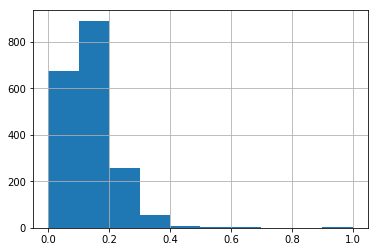

In [20]:
# We will clamp those values to improve the spread of the weights 

df_pests_merge["Weight"].hist()
print("# weights in the two last thirds of weight-space:", df_pests_merge[df_pests_merge["Weight"] > .33].count()["NTA"])


Unfortunaterly, a small number of NTAs offset our weights into a small range. We will clamp those weights to re-center the distribution into a better range for visualization purposes.

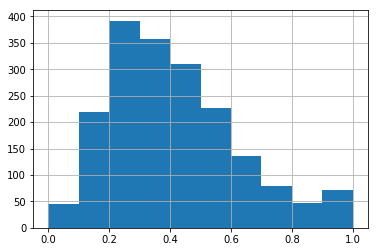

In [21]:

df_pests_merge["Weight"] = df_pests_merge["Weight"].apply(lambda x: .33 if x > .33 else x)
_min, _max = df_pests_merge["Weight"].min(), df_pests_merge["Weight"].max()
df_pests_merge["Weight"] = (df_pests_merge["Weight"] - _min) / (_max - _min)
df_pests_merge["Weight"].hist()

#### Interactive map of our results 

We now generate the timelapse of the change of those weights by NTA. If our normalization is good enough, it should give us an insight into the "true" change of pests sightings intensity of NYC.

In [22]:
df_pests_merge.head()

NTA  Year  Count   Borough                      NTA Name  Population  \
0  BK09  2010     44  Brooklyn  Brooklyn Heights-Cobble Hill       22887   
1  BK09  2011     55  Brooklyn  Brooklyn Heights-Cobble Hill       22887   
2  BK09  2012     51  Brooklyn  Brooklyn Heights-Cobble Hill       22887   
3  BK09  2013     29  Brooklyn  Brooklyn Heights-Cobble Hill       22887   
4  BK09  2014     58  Brooklyn  Brooklyn Heights-Cobble Hill       22887   

   Capita Count  Year Count    Norm Count    Weight  
0      0.001922       26867  7.155577e-08  0.245702  
1      0.002403       26143  9.192177e-08  0.317941  
2      0.002228       25522  8.731053e-08  0.301585  
3      0.001267       25714  4.927646e-08  0.166675  
4      0.002534       27880  9.089633e-08  0.314304

In [23]:
features = plotting.get_features(df_pests_merge, geojson, "NTA", "Year", "ntacode", "Weight")


In [25]:

m = plotting.map_features(features)
m.save("maps/Pests.html")

Unfortunately, github will not display the interactive map properly in notebook preview form. Consult the github Pages website for the interactive map, or see snapshots for 2011 and 2018 below: 

![2011](images/2011.png)

![2018](images/2019.png)

The following conclusions can be made from the timelapse.

- Clinton Hill, Prospect Heights, Stuyvesant and Bedford, at the center of Brooklyn, have fluctuating intensities over the years but consistently stay at the most pest-affected NTAs of the city.
- During the early years of the decade, Staten Island is impacted more in the southern part. Over the decade, the southern part seems to be left alone by rats gradually, and inversly the nothern part slightly increases in weight. In general the pest intensity slightly subsides over the decade on Staten Island. 
- Southern Queens starts off as a hotspot for pest reporting. It gradually calms over the decade, but stays overall the most affected area in Queens.
- In Central Harlem South, the problem is very intense throughout the decade. Melrose South-Mott Haven North, in the Bronx, witnesses a mostly constant increase in weight over the decade.
- Southern Manhattan appears to gradually become more affected at the first half of the decade which then diminished after 2015.

Here are the areas comparatively unaffected by the problem:
- Southern Brooklyn, especially south of Prospect park.
- North-eastern Queens, east of Flushing-Meadows-Park but above the Grand Central parkway (south of the parkway, Jamaica, is affected).
- South Staten Island since the improvements of the early part of the decade.


Here is our top-10 of pest-spared Neighborhoods using the Weight as a metric

In [26]:
df_pests_merge.drop_duplicates("NTA").sort_values(by="Weight", ascending=True).head(10)["NTA Name"]

870                            Rikers Island
790                              Parkchester
470                            Starrett City
1155          Stuyvesant Town-Cooper Village
1565                             Murray Hill
1325                                Flushing
1465                    Fresh Meadows-Utopia
140                         Sunset Park East
1505    Douglas Manor-Douglaston-Little Neck
1525        Ft. Totten-Bay Terrace-Clearview
Name: NTA Name, dtype: object

And here is our bottom-10 of pest-afflicted Neighborhoods to avoid if you prefer sanitary conditions!

In [27]:
df_pests_merge.drop_duplicates("NTA").sort_values(by="Weight", ascending=False).head(10)["NTA Name"]

390                 Ocean Hill
300           Prospect Heights
150         Stuyvesant Heights
1175             South Jamaica
905           Hamilton Heights
935       Central Harlem South
690                   Longwood
1725              Baisley Park
1904    New Dorp-Midland Beach
320               Clinton Hill
Name: NTA Name, dtype: object

# Appendix: analyses not included in the data story

## Analysis of noise complaints

In [81]:
%matplotlib inline

# Imports for this part
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from shapely.geometry import shape, Point

sns.set()

**Noise complaints** being among the most frequent complaints, we do a small analysis of that type of complaints, to get a better understanding of it and be able to re-use general analysis methods for other types of complaints. This analysis is not complete, but shows that we have an improved knowledge of our data, which will allow us to develop robust methods for the upcoming milestone. 

In [82]:
path_311 = "data/311_Service_Requests_from_2010_to_Present_small.pkl"
path_noise = "data/311_Noise_Complaints.pkl"
path_nta = "data/Neighborhood Tabulation Areas.geojson"
path_nta_population = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"

In [83]:
# df_311 = pd.read_pickle(path_311)
df_nta_population = pd.read_csv(path_nta_population)

In [84]:
df_311.head()

Unique Key        Created Date         Closed Date Agency  \
0    32438412 2016-01-17 22:12:35 2016-01-17 23:14:02   NYPD   
1    32438413 2016-01-17 15:23:56 2016-01-17 19:28:40   NYPD   
2    32438414 2016-01-17 19:04:42 2016-01-19 08:49:00    DOT   
3    32438415 2016-01-17 18:46:31 2016-01-17 19:51:41   NYPD   
4    32438416 2016-01-18 00:02:23 2016-01-18 16:51:22   NYPD   

                       Agency Name       Complaint Type        Descriptor  \
0  New York City Police Department  Noise - Residential  Banging/Pounding   
1  New York City Police Department  Noise - Residential  Banging/Pounding   
2     Department of Transportation     Street Condition           Pothole   
3  New York City Police Department   Noise - Commercial  Loud Music/Party   
4  New York City Police Department  Noise - Residential  Banging/Pounding   

                Location Type Incident Zip      Incident Address  ...  \
0  Residential Building/House        10468  2386 DAVIDSON AVENUE  ...   
1  Residential Building/House        10032   551 WEST 170 STREET  ...   
2                         NaN        11103       30-50 44 STREET  ...   
3            Store/Commercial        11203    3820 CHURCH AVENUE  ...   
4  Residential Building/House        11226     1050 OCEAN AVENUE  ...   

  Vehicle Type Taxi Company Borough Taxi Pick Up Location Bridge Highway Name  \
0          NaN                  NaN                   NaN                 NaN   
1          NaN                  NaN                   NaN                 NaN   
2          NaN                  NaN                   NaN                 NaN   
3          NaN                  NaN                   NaN                 NaN   
4          NaN                  NaN                   NaN                 NaN   

  Bridge Highway Direction Road Ramp Bridge Highway Segment   Latitude  \
0                      NaN       NaN                    NaN  40.861404   
1                      NaN       NaN                    NaN  40.841828   
2                      NaN       NaN                    NaN  40.761218   
3                      NaN       NaN                    NaN  40.651177   
4                      NaN       NaN                    NaN  40.636969   

   Longitude Quantity  
0 -73.903217      1.0  
1 -73.937822      1.0  
2 -73.912766      1.0  
3 -73.941618      1.0  
4 -73.958533      1.0  

[5 rows x 39 columns]

For the noise complaints analysis we only need a few columns, the rest can be disregarded:

In [86]:
col_selection = ['Created Date', 'Complaint Type', 'Latitude', 'Longitude']
noise_complaints = df_311[col_selection]

In [87]:
complaints = df_311["Complaint Type"].unique().tolist()

In [88]:
complaints_lowercase = list(map(lambda x: (x, x.lower()), complaints))
noise_complaint_types = [complaint[0] for complaint in complaints_lowercase if "noise" in complaint[1]]
print(noise_complaint_types)

['Noise - Residential', 'Noise - Commercial', 'Noise - Vehicle', 'Noise', 'Noise - Street/Sidewalk', 'Noise - House of Worship', 'Noise - Helicopter', 'Collection Truck Noise', 'Noise - Park', 'Noise Survey']


In [89]:
noise_complaint_types = noise_complaint_types[:-1]

In [90]:
noise_complaints = df_311[df_311["Complaint Type"].isin(noise_complaint_types)]

We focus on noise complaints over a period of 11 weeks, to get more precise information about short-term trends.

In [91]:
start = datetime(2019, 8, 5)
end = datetime(2019, 10, 21)
noise_complaints = noise_complaints[(start <= noise_complaints["Created Date"]) & (noise_complaints["Created Date"] < end)].reset_index().drop(columns=["index"])

In [94]:
# Add NTA column
noise_complaints["NTA"] = np.nan
noise_complaints.loc[noise_complaints.Latitude.notnull(), "NTA"] = noise_complaints[noise_complaints.Latitude.notnull()].apply(get_nta, axis=1)

Let's first look at the distribution of noise complaints:

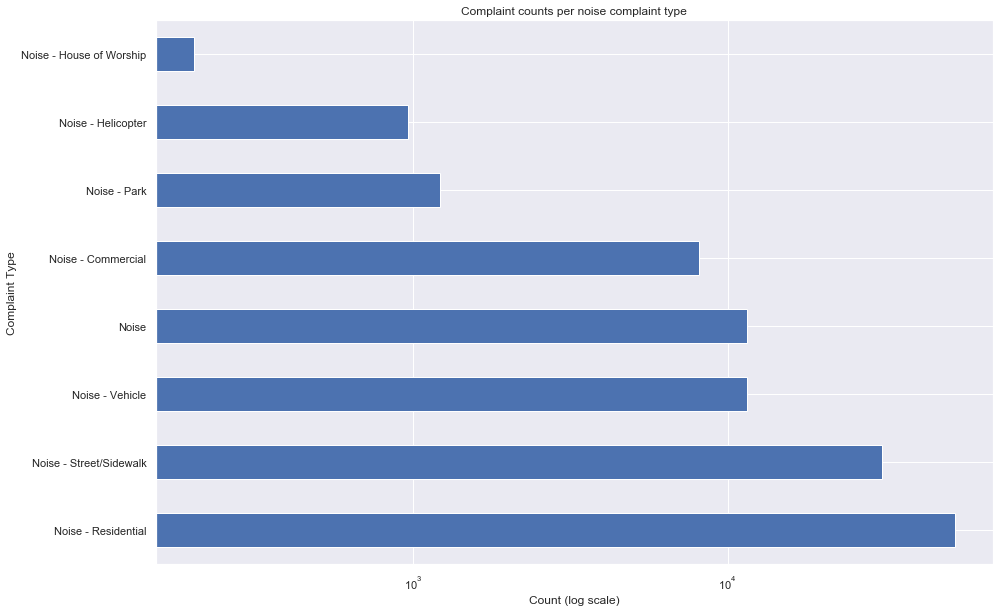

In [95]:
complaint_count = noise_complaints.groupby("Complaint Type") \
                                  .count()["Created Date"] \
                                  .sort_values(ascending=False) 
      
complaint_count = complaint_count[complaint_count != 0]
ax = complaint_count.plot.barh(logx=True, figsize=(15, 10))
ax.set_title("Complaint counts per noise complaint type")
ax.set_xlabel("Count (log scale)");

### Analyse noise based on time of the day

In the **Seasonality** section, we saw that different types of complaints experience different seasonal patterns. Let's see what happens for noise complaints:

In [96]:
# Add columns for date, weekday and hour of creation
noise_complaints["Created Day"] = noise_complaints["Created Date"].dt.date
noise_complaints["Created Hour"] = noise_complaints["Created Date"].dt.hour
noise_complaints["Created Weekday"] = noise_complaints["Created Date"].dt.dayofweek

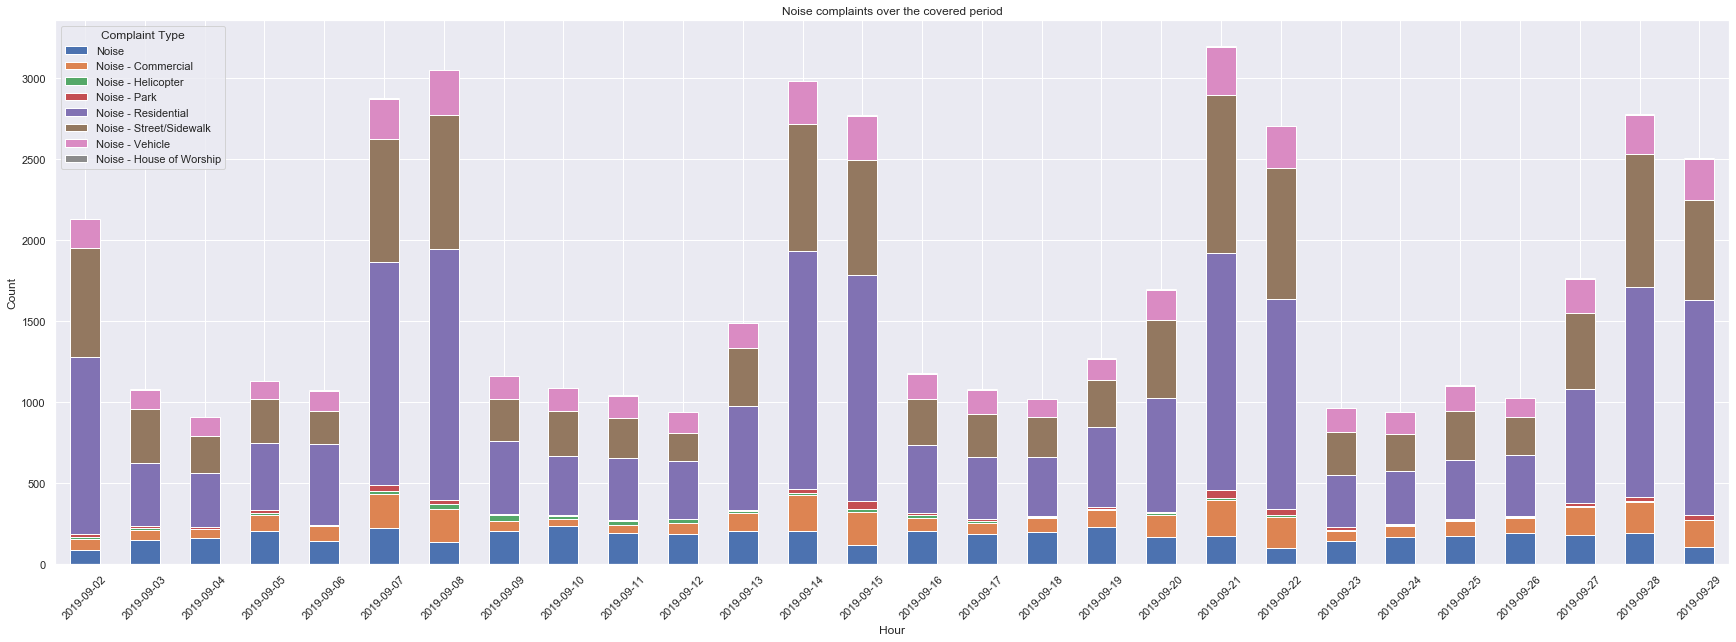

In [97]:
# Use a period of one month for plotting
month_start = datetime(2019, 9, 2)
month_end = datetime(2019, 9, 30)

# Filter complaints and group by the creation date, and distinguish noise complaint types
daily_complaints = noise_complaints[(month_start <= noise_complaints["Created Date"]) & (noise_complaints["Created Date"] < month_end)] \
                            .groupby(['Created Day', 'Complaint Type'])['Created Day'] \
                            .count() \
                            .unstack('Complaint Type') \
                            .fillna(0)

ax = daily_complaints.plot(kind='bar', stacked=True, figsize=(30,10), rot=45)
ax.set_title("Noise complaints over the covered period")
ax.set_xlabel("Hour")
ax.set_ylabel("Count");

Seasonality is obvious, there is a weekly pattern, with a peak in noise complaints over the weekend. 

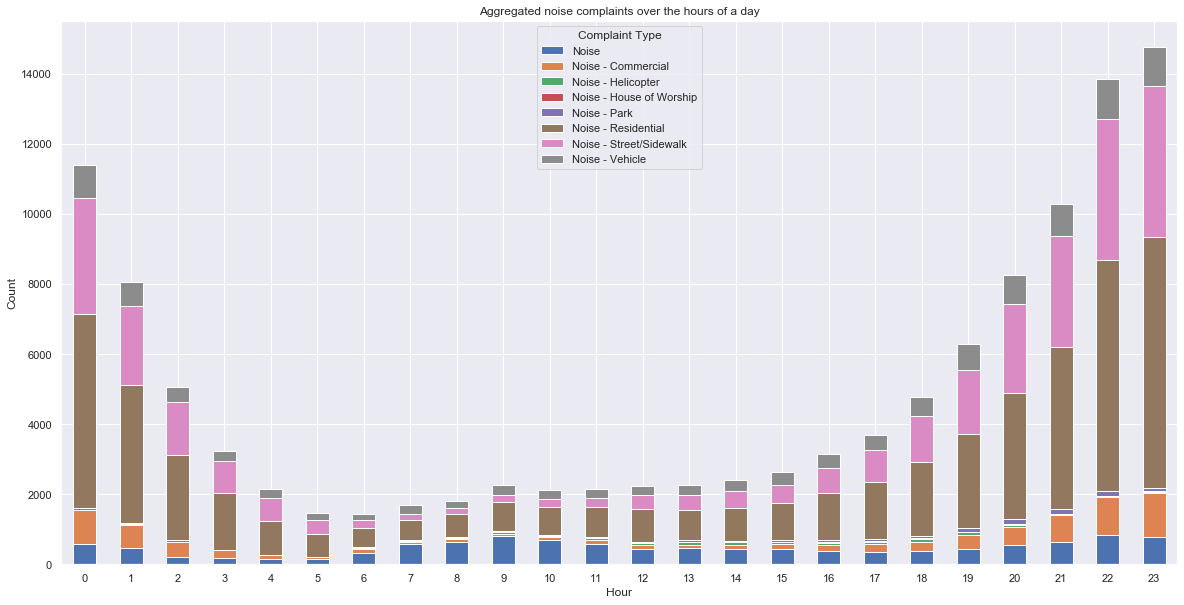

In [98]:
hourly_complaints = noise_complaints.groupby(['Created Hour', 'Complaint Type'])['Created Hour'].count().unstack('Complaint Type').fillna(0)
ax = hourly_complaints.plot(kind='bar', stacked=True, figsize=(20,10), rot=0)
ax.set_title("Aggregated noise complaints over the hours of a day")
ax.set_xlabel("Hour")
ax.set_ylabel("Count");

There is also a daily pattern, with lots of noise complaints during the night. We might want to look at the pattern we get when aggregating based on the hour and the weekday, to see if there are differences and validate our current approach (disregard weekday). We expect to have a similar pattern every day, but with different numbers. The previous plots don't really show the relative evolution of the different noise complaints, let's try to normalize complaint counts to get a clearer picture.

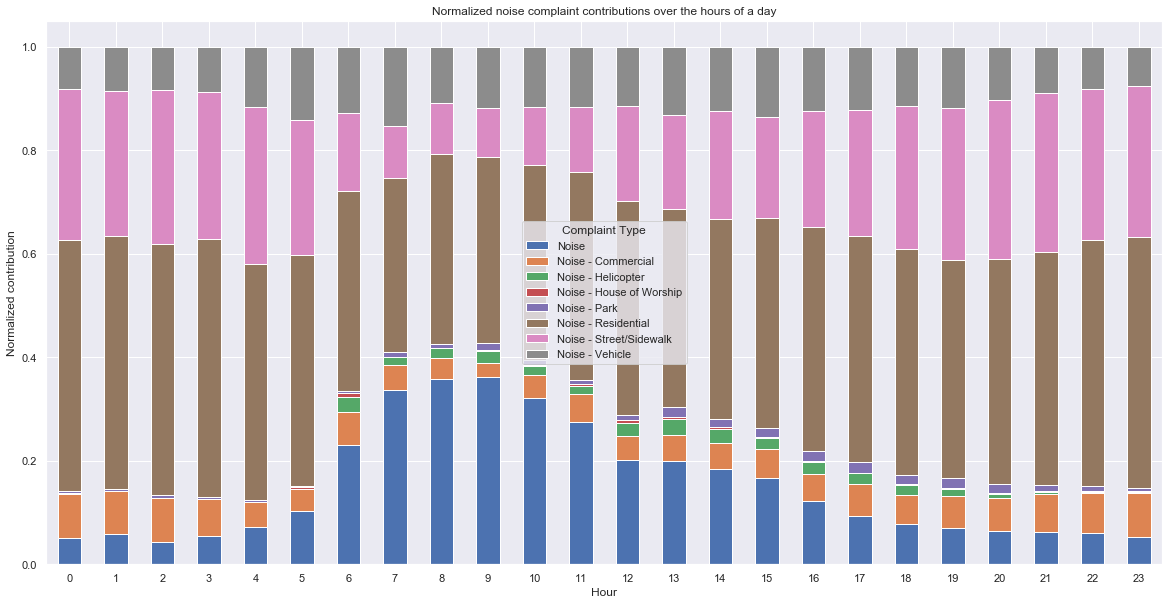

In [99]:
# Normalize hourly noise complaint count
hourly_complaints_normalized = hourly_complaints.div(hourly_complaints.sum(axis=1), axis=0)
ax = hourly_complaints_normalized.plot(kind='bar', stacked=True, figsize=(20,10), rot=0)
ax.set_title("Normalized noise complaint contributions over the hours of a day")
ax.set_xlabel("Hour")
ax.set_ylabel("Normalized contribution");

Within the noise complaint category, we can distinguish between night-time and day-time complaints as follows:
- Day-time: Noise, Noise - Helicopter, Noise - House of Worship, Noise-Park, Noise - Vehical
- Night-time: Noise - Residential, Noise - Street/Sidewalk

So far we assumed that the distribution of noise complaints does not depend on the weekday, let's check if that assumption is true, by plotting the complaint distribution for every weekday:

In [100]:
hourly_complaints = noise_complaints.groupby(['Created Weekday', 'Created Hour'])[['Created Date']].count().reset_index()

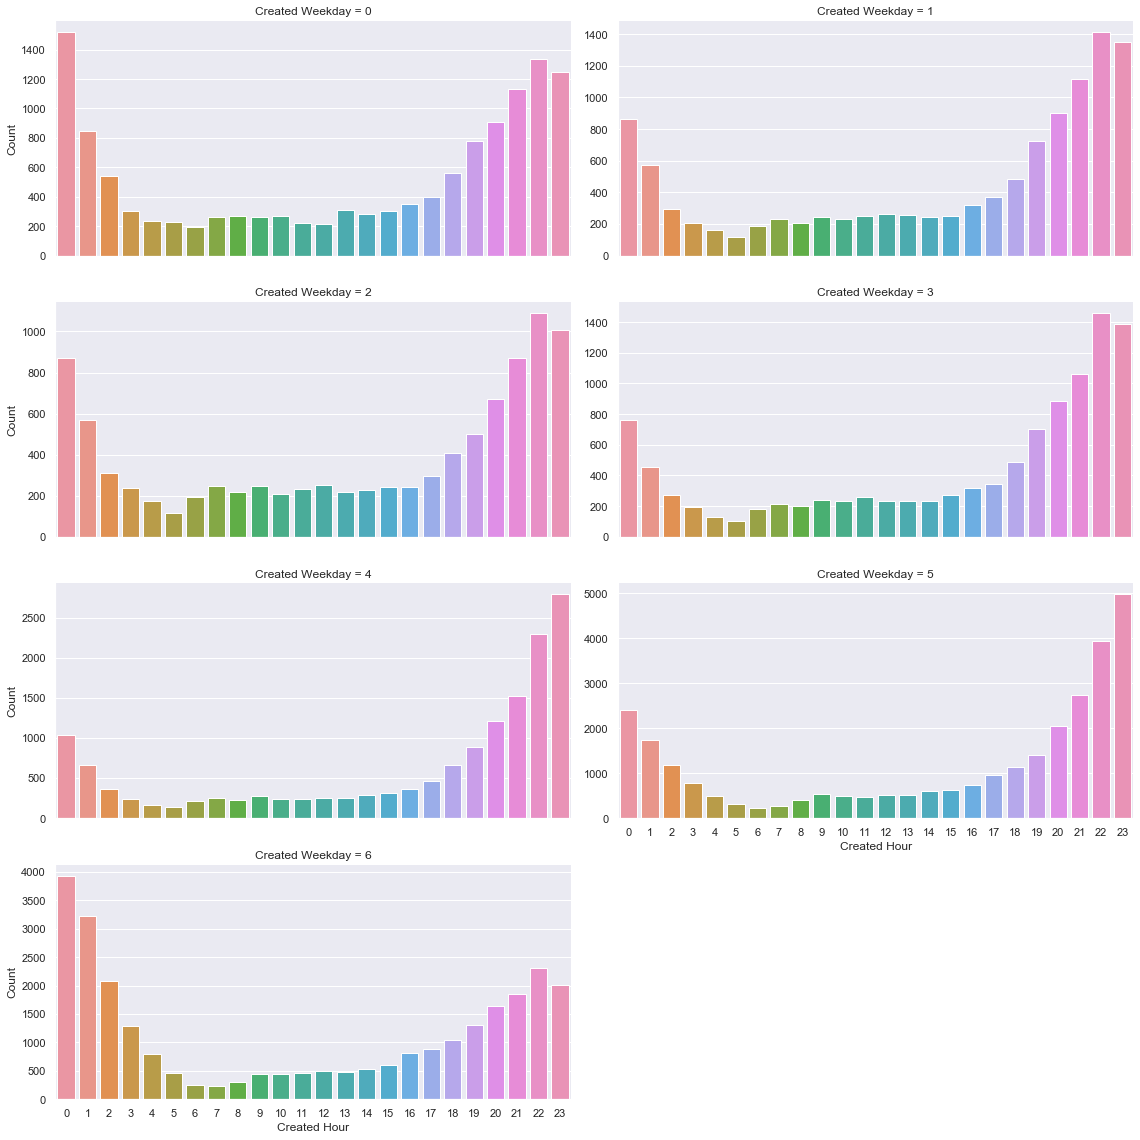

In [101]:
g = sns.catplot(x='Created Hour', y='Created Date', col='Created Weekday', data=hourly_complaints, kind='bar', col_wrap=2, sharey=False, height=4, aspect=2)
g = g.set_ylabels("Count")

The shapes are not really that different, there are just peaks on Friday and Saturday night that must be taken into account and have an effect on the last 3 plots. The following question arises: is it just party-related / nightly complaints that are responsible for the weekend peaks? The following plot tries to provide an answer to that question, by looking at the distribution of noise complaints over the weekdays, for every hour of the day:

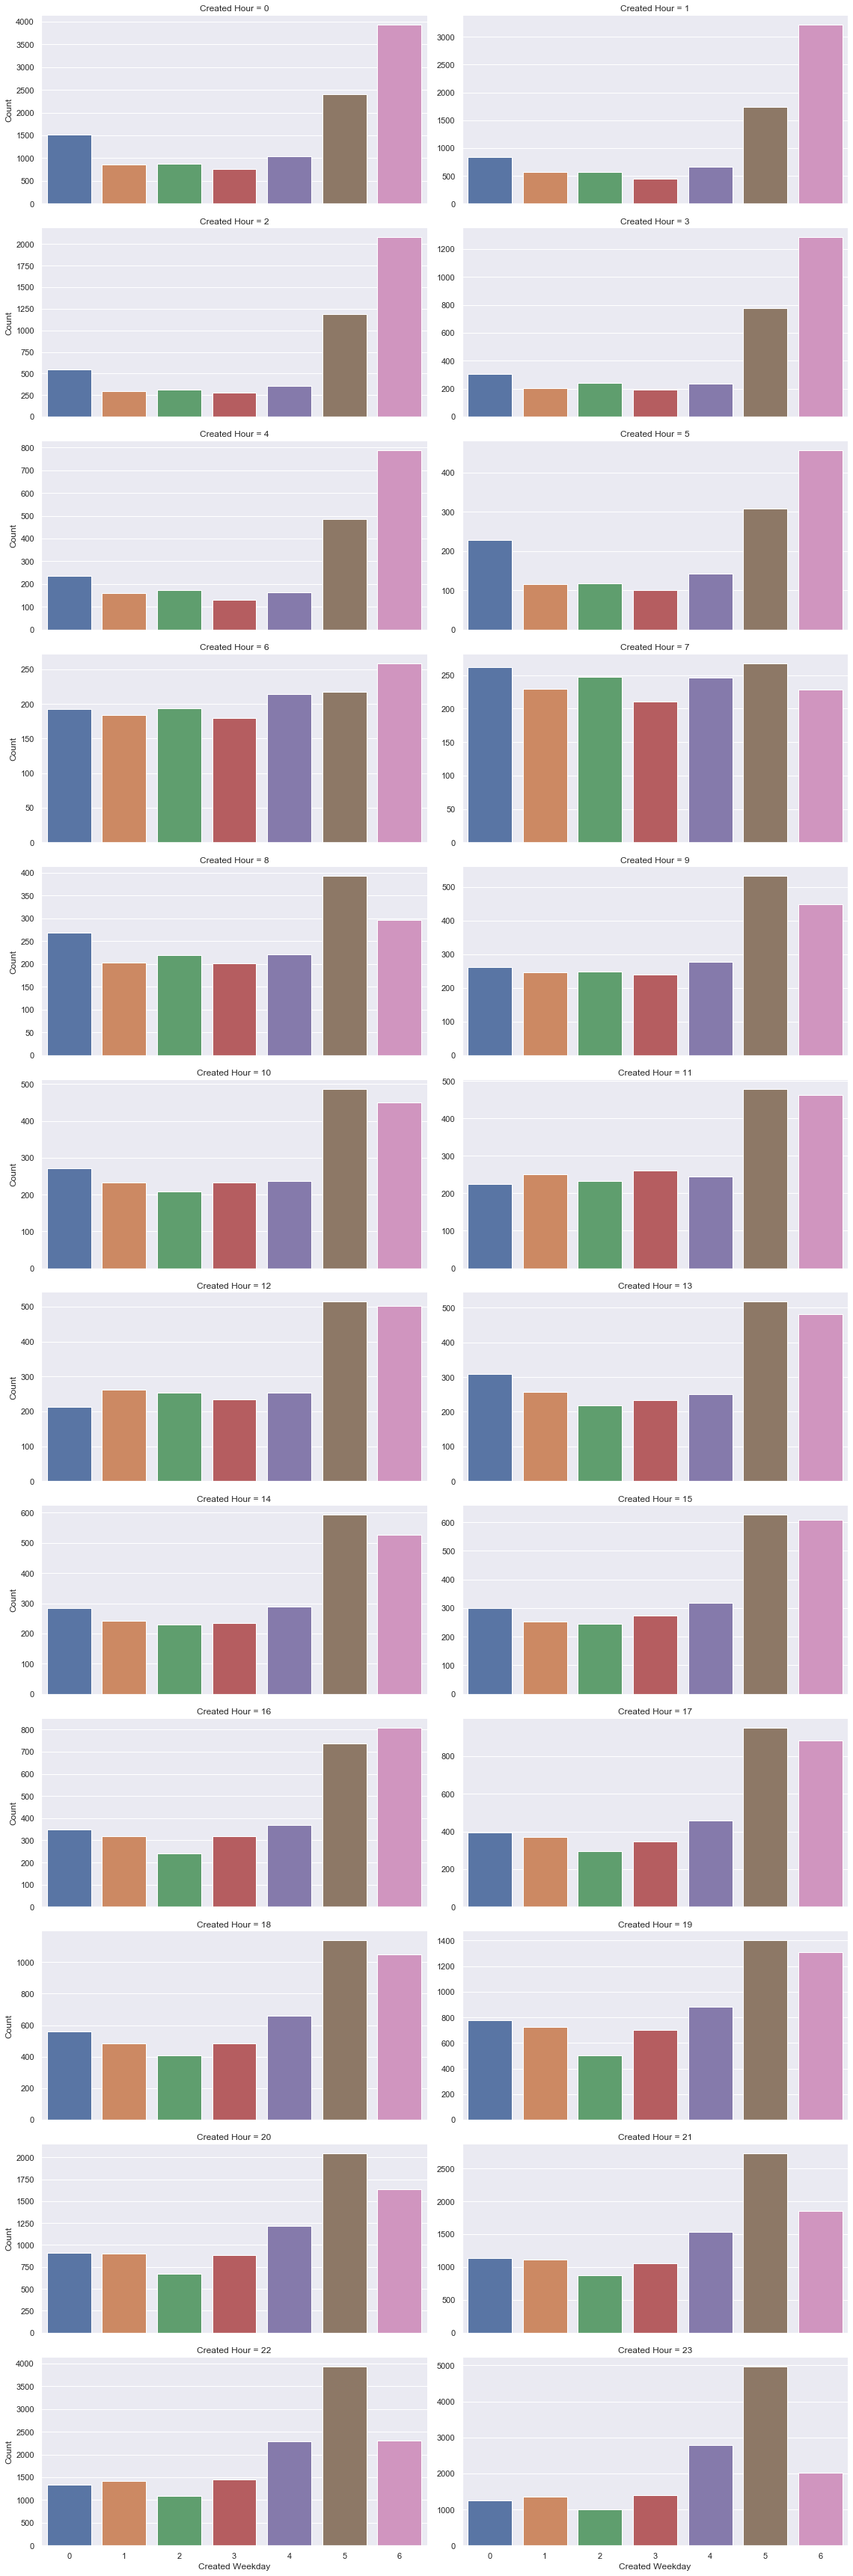

In [102]:
g = sns.catplot(x='Created Weekday', y='Created Date', col='Created Hour', data=hourly_complaints, kind='bar', col_wrap=2, sharey=False, height=4, aspect=2)
g = g.set_ylabels("Count")

Not only are there more night-time noise-complaints on the weekend, there are also more day-time complaints, probably because people tend to be at home over the weekend, where they are more likely to be disturbed than at work. We notice that night-time complaints contribute a lot to the weekend-peak, this can be seen on the Friday evening/Saturday morning and Saturday evening/Sunday morning plots. 

## Investigating how agencies are split to take care of smaller regions in NYC

In [56]:
school_agencies = [agency for agency in list(df_311["Agency Name"].unique()) if "School - " in agency]
len(school_agencies)

1791

In [57]:
df_311[df_311["Agency Name"].isin(school_agencies)]["Agency"].unique()

[DOE]
Categories (1, object): [DOE]

Many of the agencies are schools. All of them are mapped to agency "DOE". Schools are divided into NYC school districts. The map of such districts is available https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj , but we don't see a dataset that could map 3-1-1 Agency Names to school districts.

In [58]:
not_school_agencies = [agency for agency in list(df_311["Agency Name"].unique()) if not "School - " in agency]
len(not_school_agencies)

141

In [59]:
df_311[df_311["Agency"] == "NYPD"]["Agency Name"].unique()

[New York City Police Department, NYPD, Investigation Review Section, Traffic Management Center, New York Police Precinct]
Categories (5, object): [New York City Police Department, NYPD, Investigation Review Section, Traffic Management Center, New York Police Precinct]

We see that a single "Agency" entry maps to multiple "Agency Name" entries that in some cases are equivallent, such as "NYPD" and "New York City Police Department". This indicates that we should first look at the "Agencies" themselves as "Agency Names" may not be meaningful.

NYPD is split into Police Precints: https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz

In [61]:
list(df_311[df_311["Agency"] == "OMB"]["Agency Name"].unique())

['OMB']

DSNY (Department of Sanitation) districts: https://data.cityofnewyork.us/City-Government/DSNY-Districts/6j86-5s7z

FDNY (Fire Division). Battallions: https://data.cityofnewyork.us/Public-Safety/Fire-Battalions/uh7r-6nya , divisions (coarse grained): https://data.cityofnewyork.us/Public-Safety/Fire-Divisions/hkpx-aaxc

Overall, we have found geographical subdivisions for DOE, NYPD, DSNY and FDNY. We decide to use only the ones for NYPD.

The metrics we are going to use:
- Median and mean complaint resolution time.
- Number of complaints normalized by population. Note that there is no data about the population of the districts of operation, which are not related to NTAs, so we approximate it by a weighted sum of the population of the NTAs overlapping with the district.

In [71]:
from python_scripts.agency_analysis import get_agencies_array
agencies = get_agencies_array(df_311)

DOE has 18133 entries
NYPD has 5097994 entries
DSNY has 1832606 entries
FDNY has 58 entries
We realize that we few complaints from Fire Departments with specified locationso we drop it. There are also not many such complaints to the department of education (~19k) and we also decide not to use if further.


TopologyException: Input geom 1 is invalid: Too few points in geometry component at or near point -73.905913525222076 40.587544309958552 at -73.905913525222076 40.587544309958552


failed for nta: QN10 with district 61


In [84]:
from python_scripts.agency_analysis import add_resolution_time
agencies_df = add_resolution_time(agencies)

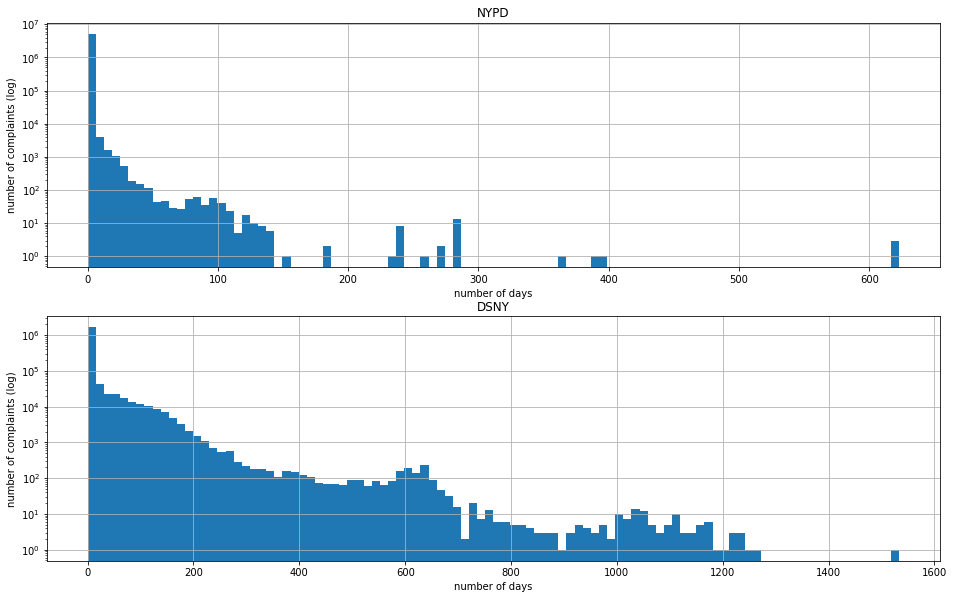

In [85]:
from python_scripts.plotting import agency_complaint_resolution
agency_resolution_plot_path = agency_complaint_resolution(agencies)

It appears that there are outliers in case of NYPD and DSNY. Histogram of the Department of Education shows unexpected spike around 1200 - 1400 days. We decide to keep those entries as they are most likely valid. Clearly most of the complaints are resolved in a single day, but there are exceptions - in case of DSNY quite many of them.

In [54]:
print("Most common call categories\n")
for i, agency in enumerate(agencies):
    print(agency_names[i])
    print(agency.groupby("Complaint Type").agg("size").sort_values(ascending=False).head(10))
    print()

Most common call categories

NYPD
Complaint Type
Noise - Residential            1762451
Blocked Driveway                891486
Illegal Parking                 871447
Noise - Street/Sidewalk         459908
Noise - Commercial              341325
Noise - Vehicle                 209198
Derelict Vehicle                206187
Non-Emergency Police Matter      66316
Animal Abuse                     51999
Vending                          41218
dtype: int64

DSNY
Complaint Type
Dirty Conditions                       334757
Request Large Bulky Item Collection    325106
Sanitation Condition                   288091
Missed Collection (All Materials)      250855
Derelict Vehicles                      197538
Graffiti                               153017
Snow                                    75624
Other Enforcement                       57148
Electronics Waste Appointment           32624
Electronics Waste                       26473
dtype: int64



We realize that even though the calls are supposedly complaints, they cannot always be classified as such. This is the case for many of the DSNY calls as it appears to be receiving regular requests for garbage collection through 311. We see that noise is disturbing the people in NYC most, followed by parking issues. Many call to report "Dirty Conditions" in general.

In [28]:
agencies[1].groupby("Complaint Type").agg("size").sort_values(ascending=False).head(30)

Complaint Type
Dirty Conditions                       334757
Request Large Bulky Item Collection    325106
Sanitation Condition                   288091
Missed Collection (All Materials)      250855
Derelict Vehicles                      197538
Graffiti                               153017
Snow                                    75624
Other Enforcement                       57148
Electronics Waste Appointment           32624
Electronics Waste                       26473
Litter Basket / Request                 24845
Vacant Lot                              17176
Derelict Bicycle                        12770
Overflowing Litter Baskets              10715
Recycling Enforcement                    8408
Sweeping/Missed                          5649
Sweeping/Missed-Inadequate               5490
Request Xmas Tree Collection             1936
Sweeping/Inadequate                      1782
Collection Truck Noise                   1498
Adopt-A-Basket                            555
Missed Collection  

We decide to drop the calls categorized as:
- Request Large Bulky Item Collection
- Electronics Waste Appointment
- Electronics Waste
- Litter Basket / Request
- Request Xmas Tree Collection
- Adopt-A-Basket

In [88]:
from python_scripts.agency_analysis import clean_dsny
agencies_df[1] = clean_dsny(agencies_df[1])

In [90]:
for i, agency in enumerate(agencies_df):
    print(f"{agency_names[i]} entries: {len(agency)}")
    print("NaNs:")
    print(agency.isna().sum())
    print()

NYPD entries: 5097994
NaNs:
Created Date                 0
Closed Date               5126
Complaint Type               0
Latitude                     0
Longitude                    0
District                   483
Resolution Time (days)    5126
dtype: int64

DSNY entries: 1421067
NaNs:
Created Date                  0
Closed Date               14870
Complaint Type                0
Latitude                      0
Longitude                     0
District                   2139
Resolution Time (days)    14870
dtype: int64



We decide to drop the NaNs as they are a small minority of the calls.

In [91]:
from python_scripts.agency_analysis import remove_nans
agencies_df = remove_nans(agencies_df)

In [100]:
from python_scripts.agency_analysis import get_statistics_for_agencies
grouped_agencies = get_statistics_for_agencies(agencies_df, agencies, True)

We decide to use two metrics for ranking the agencies in districts: complaints per capita and the median resolution time. As we have seen in the histogram with resolution time, there are present outliers in the dataset and median is more robust to outliers than the mean.

In [104]:
print(agency_names[1])
# we create a value for complaints per capita in the range (0, 1), where 0 means 0 and 1 means 50 per 1k capita
grouped_agencies[1]["Complaints per capita norm"] = grouped_agencies[1]["Complaints per 1k capita"] / 50
# similarly for median resolution time in days, 1 meaning 10 days
grouped_agencies[1]["Median resolution time (days) norm"] = grouped_agencies[1]["Median resolution time (days)"] / 10
grouped_agencies[1].to_pickle("data/dsny_ranking.pkl")
grouped_agencies[1][:10]

DSNY


Mean resolution time (days)  Median resolution time (days)  \
District                                                               
107                         10.459020                       1.213889   
108                         13.264727                       1.161111   
109                         20.195355                       1.843056   
205                         23.054209                       1.929861   
106                         10.195113                       1.626736   
204                         18.284708                       1.638889   
112                         24.169903                       2.077083   
111                         17.429179                       1.379861   
207                         16.920172                       1.588194   
208                         10.277983                       1.186806   

          Number of complaints  District population  Complaints per 1k capita  \
District                                                                        
107                      13414        200571.338371                 66.878947   
108                      15220        219020.148785                 69.491323   
109                       8007        113264.247086                 70.693093   
205                       8829        120788.208561                 73.094883   
106                       9564        129661.966748                 73.761028   
204                      10739        140259.848824                 76.565033   
112                      14769        189956.632561                 77.749325   
111                       9711        120940.377683                 80.295764   
207                      11658        144203.079104                 80.844321   
208                       9473         98627.097514                 96.048654   

          Mean resolution time rank  Median resolution time rank  \
District                                                           
107                            22.0                         28.0   
108                            33.0                         21.0   
109                            50.0                         47.0   
205                            56.0                         51.0   
106                            19.0                         38.0   
204                            48.0                         40.0   
112                            57.0                         57.0   
111                            47.0                         30.0   
207                            46.0                         36.0   
208                            21.0                         23.0   

          Number of complaints rank  Complaints per 1k capita rank  \
District                                                             
107                            15.0                            1.0   
108                            20.0                            2.0   
109                             2.0                            3.0   
205                             4.0                            4.0   
106                             6.0                            5.0   
204                            10.0                            6.0   
112                            19.0                            7.0   
111                             7.0                            8.0   
207                            13.0                            9.0   
208                             5.0                           10.0   

          Complaints per capita norm  Median resolution time (days) norm  
District                                                                  
107                         1.337579                            0.121389  
108                         1.389826                            0.116111  
109                         1.413862                            0.184306  
205                         1.461898                            0.192986  
106                         1.475221                            

In [ ]:
grouped_agencies[1][:]

We note that complaints per capita correlates with the total number of complaints. That means departments having many complaints in general have many complaints even when normalized by the number of inhabitants. We see that the districts that receive many complaints per capita tend to take longer to resolve the issues.

In [99]:
print(agency_names[0])
# we create a value for complaints per capita in the range (0, 1), where 0 means 0 and 1 means ~200 per 1k capita
grouped_agencies[0]["Complaints per capita norm"] = grouped_agencies[0]["Complaints per 1k capita"] / 201
grouped_agencies[0]["Median resolution time (hours)"] = grouped_agencies[0]["Median resolution time (days)"] * 24
# similarly for median resolution time in hours, 1 meaning 15 hours
grouped_agencies[0]["Median resolution time (hours) norm"] = grouped_agencies[0]["Median resolution time (hours)"] / 15
grouped_agencies[0].to_pickle("data/nypd_ranking.pkl")
grouped_agencies[0]

NYPD


Mean resolution time (days)  \
District Created Year                                
123      2012                             0.134790   
101      2012                             0.106771   
111      2012                             0.112168   
123      2011                             0.131435   
111      2011                             0.094371   
...                                            ...   
34       2017                             1.636961   
30       2018                             0.107177   
         2017                             0.091979   
88       2016                             1.233394   
34       2018                             0.477241   

                       Median resolution time (days)  Number of complaints  \
District Created Year                                                        
123      2012                               0.095457                  1748   
101      2012                               0.073218                  1153   
111      2012                               0.081383                  2002   
123      2011                               0.094444                  1825   
111      2011                               0.069172                  2036   
...                                              ...                   ...   
34       2017                               0.235718                 20242   
30       2018                               0.059711                 10037   
         2017                               0.070833                 10153   
88       2016                               0.119317                  9655   
34       2018                               0.160845                 22163   

                       District population  Complaints per 1k capita  \
District Created Year                                                  
123      2012                104936.888290                 16.657631   
101      2012                 68240.982442                 16.896005   
111      2012                116994.866595                 17.111862   
123      2011                104936.888290                 17.391406   
111      2011                116994.866595                 17.402473   
...                                    ...                       ...   
34       2017                110307.835909                183.504643   
30       2018                 54337.153419                184.717074   
         2017                 54337.153419                186.851893   
88       2016                 50802.992302                190.047861   
34       2018                110307.835909                200.919543   

                       Mean resolution time rank  Median resolution time rank  \
District Created Year                                                           
123      2012                              388.0                        421.0   
101      2012                              197.0                        192.0   
111      2012                              247.0                        305.0   
123      2011                              367.0                        412.0   
111      2011                               96.0                        158.0   
...                                          ...                          ...   
34       2017                              746.0                        735.0   
30       2018                              201.0                         70.0   
         2017                               82.0                        175.0   
88       2016                              745.0                        570.0   
34       2018                              728.0                        683.0   

                       Number of complaints rank  \
District Created Year                              
123      2012                               21.0   
101      2012                                5.0   
111      2012                               35.0   
123      2011                               25.0   
11

Observations from DSNY appear to generalize to NYPD as well.